To run the code, upload to Colab and run cells in-order. For best results, use a GPU runtime.

# Utilities

## Installations

In [ ]:
!pip3 install emoji==1.7
!pip3 install clean-text

print("\ntensorflow:")
!pip install -q -U "tensorflow==2.9.*"
print("\ntensorflow-text:")
!pip install -q -U "tensorflow-text==2.9.*"
print("\ntf-models-official:")
!pip install -q -U "tf-models-official==2.9.*"
print("\ntensorflow-addons:")
!pip install -q "tensorflow-addons"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
tensorflow
     |████████████████████████████████| 511.8 MB 23 kB/s 
tensorflow-text
tf-models-official
tensorflow-addons


## Imports

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import collections
import emoji
import math
from cleantext import clean
import cleantext
from emoji.core import replace_emoji

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

import nltk
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import RegexpTokenizer

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from torch.nn import LSTM
import spacy
from sklearn.metrics import f1_score
from collections import Counter
from torchtext.data.utils import get_tokenizer
from string import punctuation

## Numpy utility functions

In [ ]:
def as_1d(v):
    """Convert row or column vector to 1D
    """
    v_1d = np.atleast_1d(np.squeeze(v))
    if (len(v_1d.shape) != 1):
        raise Exception(f"Array is not a vector, has squeezed dimension {v_1d.shape}")
    return v_1d

def as_col(v):
    """Convert vector to column
    """
    return as_1d(v).reshape(-1, 1)
    
def as_row(v):
    """Convert vector to row
    """
    return as_1d(v).reshape(1, -1)

# Intialize data

### Get files from GitHub

In [ ]:
# Install subversion to use svn
!apt-get install subversion

# Get what you want by adding "/trunk" to the repo url and the folder you want
#!svn checkout REPO_URL/trunk/DIRECTORY
!svn checkout https://github.com/NoamElul/cis-5300-final.git/trunk/data

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1
Suggested packages:
  db5.3-util libapache2-mod-svn subversion-tools
The following NEW packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 subversion
0 upgraded, 5 newly installed, 0 to remove and 20 not upgraded.
Need to get 2,235 kB of archives.
After this operation, 9,916 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libapr1 amd64 1.6.3-2 [90.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libaprutil1 amd64 1.6.1-2 [84.4 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libserf-1-1 amd64 1.3.9-6 [44.4 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates/unive

### Read datasets

In [ ]:
class DatasetTwitter(object):
    def __init__(self, folder_path, name = None):
        if name is None:
            self.string_rep = str(folder_path)
        else:
            self.string_rep = name

        self.train = pd.read_csv(Path(folder_path) / "train.tsv", sep='\t')
        self.dev = pd.read_csv(Path(folder_path) / "dev.tsv", sep='\t')
        self.test = pd.read_csv(Path(folder_path) / "test.tsv", sep='\t')

        self.train_x = as_col(self.train["text"].to_numpy()) # (n x 1) array
        self.train_y = as_1d(self.train["problematic"].to_numpy()) # (n) array

        self.dev_x = as_col(self.dev["text"].to_numpy()) # (n x 1) array
        self.dev_y = as_1d(self.dev["problematic"].to_numpy()) # (n) array

        self.test_x = as_col(self.test["text"].to_numpy()) # (n x 1) array
        self.test_y = as_1d(self.test["problematic"].to_numpy()) # (n) array

    def __repr__(self):
        return str(self.string_rep)

    def __str__(self):
        return self.__repr__()

In [ ]:
class DatasetReddit(object):
    def __init__(self, folder_path, name = None):
        if name is None:
            self.string_rep = str(folder_path)
        else:
            self.string_rep = name

        self.train = pd.read_csv(Path(folder_path) / "cad_v1_1_train.tsv", sep='\t')
        self.dev = pd.read_csv(Path(folder_path) / "cad_v1_1_dev.tsv", sep='\t')
        self.test = pd.read_csv(Path(folder_path) / "cad_v1_1_test.tsv", sep='\t')

        self.train_x = as_col(self.train["text"].to_numpy()) # (n x 1) array
        self.train_y_old = as_1d(self.train["labels"].to_numpy()) # (n) array
        #Convert all Neutral labels to 0, else to 1
        
        self.train_y = np.arange(len(self.train_y_old))
        for i in range(len(self.train_y_old)):
          if self.train_y_old[i] != "Neutral":
            self.train_y[i] = 1
          else:
            self.train_y[i] = 0

        self.dev_x = as_col(self.dev["text"].to_numpy()) # (n x 1) array
        self.dev_y_old = as_1d(self.dev["labels"].to_numpy()) # (n) array
        
        self.dev_y = np.arange(len(self.dev_y_old))
        for i in range(len(self.dev_y_old)):
          if self.dev_y_old[i] != "Neutral":
            self.dev_y[i] = 1
          else:
            self.dev_y[i] = 0

        self.test_x = as_col(self.test["text"].to_numpy()) # (n x 1) array
        self.test_y_old = as_1d(self.test["labels"].to_numpy()) # (n) array
        
        self.test_y = np.arange(len(self.test_y_old))
        for i in range(len(self.test_y_old)):
          if self.test_y_old[i] != "Neutral":
            self.test_y[i] = 1
          else:
            self.test_y[i] = 0

    def __repr__(self):
        return str(self.string_rep)

    def __str__(self):
        return self.__repr__()

In [ ]:
class DatasetPolitical(object):
    def __init__(self, folder_path, name = None):
        if name is None:
            self.string_rep = str(folder_path)
        else:
            self.string_rep = name

        self.train = pd.read_csv(Path(folder_path) / "political_train.tsv", sep='\t')
        self.dev = pd.read_csv(Path(folder_path) / "political_dev.tsv", sep='\t')
        self.test = pd.read_csv(Path(folder_path) / "political_test.tsv", sep='\t')

        self.train_x = as_col(self.train["text"].to_numpy()) # (n x 1) array
        self.train_y = as_1d(self.train["HOF"].to_numpy()) # (n) array

        self.dev_x = as_col(self.dev["text"].to_numpy()) # (n x 1) array
        self.dev_y = as_1d(self.dev["HOF"].to_numpy()) # (n) array

        self.test_x = as_col(self.test["text"].to_numpy()) # (n x 1) array
        self.test_y = as_1d(self.test["HOF"].to_numpy()) # (n) array

    def __repr__(self):
        return str(self.string_rep)

    def __str__(self):
        return self.__repr__()

In [ ]:
class DatasetWikipedia(object):
    def __init__(self, folder_path, name = None):
        if name is None:
            self.string_rep = str(folder_path)
        else:
            self.string_rep = name

        self.train = pd.read_csv(Path(folder_path) / "train.csv", sep=',', on_bad_lines='skip')
        self.dev = pd.read_csv(Path(folder_path) / "dev.csv", sep=',', on_bad_lines='skip')
        self.test = pd.read_csv(Path(folder_path) / "test.csv", sep=',', on_bad_lines='skip')

        self.train_x = as_col(self.train["comment_text"].to_numpy()) # (n x 1) array
        self.train_y = as_1d(self.train["hate_speech"].to_numpy()) # (n) array

        self.dev_x = as_col(self.dev["comment_text"].to_numpy()) # (n x 1) array
        self.dev_y = as_1d(self.dev["hate_speech"].to_numpy()) # (n) array

        self.test_x = as_col(self.test["comment_text"].to_numpy()) # (n x 1) array
        self.test_y = as_1d(self.test["hate_speech"].to_numpy()) # (n) array

    def __repr__(self):
        return str(self.string_rep)

    def __str__(self):
        return self.__repr__()

In [ ]:
class GenericDataset(object):
    def __init__(self, train_x, train_y, dev_x, dev_y, test_x, test_y, name):
        self.train_x = train_x
        self.train_y = train_y
        self.dev_x = dev_x
        self.dev_y = dev_y
        self.test_x = test_x
        self.test_y = test_y
        self.string_rep = name

    def __repr__(self):
        return str(self.string_rep)

    def __str__(self):
        return self.__repr__()

def subset_of_arr(arr, fraction):
    return arr[0:(int(np.floor(len(arr)*fraction)) + 1)]

def subset_of_dataset(dataset, fraction):
    return GenericDataset(
        subset_of_arr(dataset.train_x, fraction),
        subset_of_arr(dataset.train_y, fraction),
        subset_of_arr(dataset.dev_x, fraction),
        subset_of_arr(dataset.dev_y, fraction),
        subset_of_arr(dataset.test_x, fraction),
        subset_of_arr(dataset.test_y, fraction),
        f'{dataset} ({fraction * 100}%)'
    )

In [ ]:
twitter_hatespeech_loose = DatasetTwitter("data/twitter-hatespeech/with_offensive_language", "twitter_loose")
twitter_hatespeech_strict = DatasetTwitter("data/twitter-hatespeech/without_offensive_language", "twitter_strict")
reddit = DatasetReddit("data/reddit-abusive-comments", "reddit")
political = DatasetPolitical("data/political-twitter-hatespeech", "political")
wikipedia = DatasetWikipedia("data/wikipedia-toxic-comments", "wikipedia")

# Preprocessing

Removing emojis, generalizing urls, email, ids, and cleaning.

In [ ]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [ ]:
def preprocessing_dataset(x):
  
  try:
    x = re.sub('\n',' ',x)
  except:   #for the reddit dataset
    x = str(x)
    x = re.sub('\n',' ',x) 
  x = remove_emoji(x) #removes emoji
  x = clean(x, no_emoji=True) #removes emoji
  x = re.sub(r"http\S+", "<URL>", x) #replaces general url
  x = clean(x, no_urls = True, replace_with_url="<URL>") #replaces all urls
  x = clean(x, no_phone_numbers=True, replace_with_phone_number="<PHONE>") #replaces any phone num
  x = clean(x, no_emails=True, replace_with_email="<EMAIL>") #replaces any email
  x = re.sub('@[^\s]+','<USERID>',x) #replaces any userid with a generic one
  x = x.replace("newline", "") #for political dataset
  x = x.replace("linebreak", "") #for reddit
    
  return x


def preprocess_dataset(ds):
  preprocess = np.vectorize(preprocessing_dataset)
  ds.train_x = preprocess(ds.train_x)
  ds.dev_x = preprocess(ds.dev_x)
  ds.test_x = preprocess(ds.test_x)
  return ds

In [ ]:
twitter_hatespeech_loose = preprocess_dataset(twitter_hatespeech_loose)
twitter_hatespeech_strict = preprocess_dataset(twitter_hatespeech_strict)
reddit = preprocess_dataset(reddit)
political = preprocess_dataset(political)
# wikipedia = preprocess_dataset(wikipedia)

# Evaluation

We are mainly using the F1 score to evaluate, but we also print other metrics for more insights

In [ ]:
from nltk.util import print_string
import math

def nan_on_zero_div(num, den):
    if (den == 0):
        return math.nan
    elif (math.isnan(num) or math.isnan(den)):
        return math.nan
    else:
        return num / den

def print_metrics(y_pred_in, y_actual_in, classifier_name : str = None, dataset_name : str = None):
    tp = np.count_nonzero(np.logical_and(np.equal(as_1d(y_pred_in), 1), np.equal(as_1d(y_actual_in), 1)))
    tn = np.count_nonzero(np.logical_and(np.equal(as_1d(y_pred_in), 0), np.equal(as_1d(y_actual_in), 0)))
    fp = np.count_nonzero(np.logical_and(np.equal(as_1d(y_pred_in), 1), np.equal(as_1d(y_actual_in), 0)))
    fn = np.count_nonzero(np.logical_and(np.equal(as_1d(y_pred_in), 0), np.equal(as_1d(y_actual_in), 1)))

    accuracy = nan_on_zero_div((tp + tn), (tp + fp + tn + fn))
    precision = nan_on_zero_div(tp, (tp + fp))
    sensitivity = nan_on_zero_div(tp, (tp + fn))
    specificity = nan_on_zero_div(tn, (tn + fp))
    f1 = nan_on_zero_div((2 * tp), ((2 * tp) + fp + fn))

    if dataset_name is not None:
        print(dataset_name)
    if classifier_name is not None:
        print(classifier_name)
    print(f"accuracy: {accuracy}")
    print(f"precision: {precision}")
    print(f"sensitivity: {sensitivity}")
    print(f"specificity: {specificity}")
    print(f"f1: {f1}")
    print(f"TP: {tp}, FP: {fp}")
    print(f"TN: {tn}, FN: {fn}") 
    print()

# Milestone 2

## EDA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Count of hatespeech is: 834
Count of non-hatespeech is: 3692
Percentage of hatespeech is: 0.18426866990720284


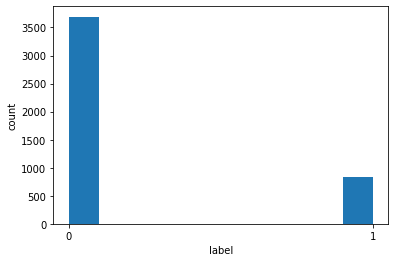

In [ ]:
def count_labels(dataset):
  print('Count of hatespeech is: ' + str(np.count_nonzero(dataset)))
  print('Count of non-hatespeech is: ' + str(len(dataset) - np.count_nonzero(dataset)))
  print('Percentage of hatespeech is: '+ str(np.count_nonzero(dataset) / len(dataset)))
  plt.hist(dataset)
  plt.xlabel('label')
  plt.ylabel('count')
  plt.xticks(range(0, 2, 1))
  plt.show()

count_labels(reddit.dev_y)

In [ ]:
def most_common_words(dataset):
  dataset = str(wikipedia.dev_x)
  stopwords = set(line.strip() for line in open('stopwords.txt'))
  stopwords = stopwords.union(set(['mr','mrs','one','two','said']))
  wordcount = {}
  for word in dataset.lower().split():
      word = word.replace(".","")
      word = word.replace(",","")
      word = word.replace(":","")
      word = word.replace("\"","")
      word = word.replace("!","")
      word = word.replace("â€œ","")
      word = word.replace("â€˜","")
      word = word.replace("*","")
      if word not in stopwords:
          if word not in wordcount:
              wordcount[word] = 1
          else:
              wordcount[word] += 1
  n_print = int(input("How many most common words to print: "))
  print("\nThe {} most common words are as follows\n".format(n_print))
  word_counter = collections.Counter(wordcount)
  for word, count in word_counter.most_common(n_print):
      print(word, ": ", count)
  lst = word_counter.most_common(n_print)
  df = pd.DataFrame(lst, columns = ['Word', 'Count'])
  df.plot.bar(x ='Word',y ='Count')

try:
    most_common_words(wikipedia.dev_x)
except:
    pass

In [ ]:
def count_emojis(dataset):
  print(emoji.emoji_count(str(dataset)))

count_emojis(reddit.dev_x)

0


## Simple Baselines: Majority and Proprtional

In [ ]:
class MajorityClassifier(object):
    def __init__(self):
        self.majority = None
        self.output_dtype = None
        return

    def fit(self, X, y):
        self.majority = np.argmax(np.bincount(y.flat))
        self.output_dtype = y.dtype
        return

    def predict(self, X):
        y = np.empty(shape=(len(X),), dtype=self.output_dtype)
        y.fill(self.majority)
        return y

In [ ]:
import random
class ProportionalClassifier(object):
    def __init__(self):
        self.fitted_y = None
        return
    
    def fit(self, X, y):
        self.fitted_y = y.tolist()
        return

    def predict(self, X):
        y = np.array(random.choices(self.fitted_y, k=len(X)))
        return y

In [ ]:
def fit_simple_classifier(cls, dataset):
    cls.fit(dataset.train_x, dataset.train_y)
    dev_y_pred = cls.predict(dataset.dev_x) 
    return dev_y_pred, dataset.dev_y

In [ ]:
classifiers = [(MajorityClassifier, "Majority Classifier"), (ProportionalClassifier, "Proportional Classifier")]

datasets = [
    (twitter_hatespeech_loose, "Twitter Hatespeech (with offensive language)"),
    (twitter_hatespeech_strict, "Twitter Hatespeech (without offensive language)"),
    (political, "Political"),
    (wikipedia, "Wikipedia"),
    (reddit, "Reddit")
]

for dataset, dname in datasets:
    for classifier, cname in classifiers:
        print_metrics(*fit_simple_classifier(classifier(), dataset), cname, dname)


Twitter Hatespeech (with offensive language)
Majority Classifier
accuracy: 0.8334409296320207
precision: 0.8334409296320207
sensitivity: 1.0
specificity: 0.0
f1: 0.9091549295774648

Twitter Hatespeech (with offensive language)
Proportional Classifier
accuracy: 0.7212717882504842
precision: 0.8334950514263536
sensitivity: 0.8317195972114639
specificity: 0.1686046511627907
f1: 0.8326063778230106

Twitter Hatespeech (without offensive language)
Majority Classifier
accuracy: 0.9406068431245965
precision: 0.0
sensitivity: 0.0
specificity: 1.0
f1: 0.0

Twitter Hatespeech (without offensive language)
Proportional Classifier
accuracy: 0.8923499031633312
precision: 0.069164265129683
sensitivity: 0.06521739130434782
specificity: 0.9445778997940975
f1: 0.06713286713286715

Political
Majority Classifier
accuracy: 0.8916666666666667
precision: 0.0
sensitivity: 0.0
specificity: 1.0
f1: 0.0

Political
Proportional Classifier
accuracy: 0.7944444444444444
precision: 0.1276595744680851
sensitivity: 0.15

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

## Strong Baseline: tf-idf naive bayes

`tfidf_representation(dataset, twitter_tokens)` returns the matrix of tf-idf values for words in each document of the train, dev, and test corpuses for a given dataset. twitter_tokens determines whether the tokenizer will be a general tokenizer or one designed specifcially for tweets.

`fit_classifier` calls `tfidf_representation`, then fits a given classifier to the data and prints relevant metrics

In [ ]:
import itertools

def tfidf_representation(dataset, twitter_tokens = False, additional_datasets = [], additional_twitter_tokens = itertools.repeat(False)):
    '''
    Tokenizes text and gets tf-idf representation
    '''

    # nltk's tweet tokenizer helps handle things like emojis and links better specifically for tweets
    # For non-tweets, we'll match on one or more instance of whitespace
    if twitter_tokens:
        tokenizer = TweetTokenizer()
    else:
        tokenizer = RegexpTokenizer("\s+", gaps=True)

    # Get bag of words
    cv = CountVectorizer(stop_words='english',tokenizer = tokenizer.tokenize)

    # transform to tf-idf representation
    tf_idf = TfidfTransformer()
    train_doc_matrix = cv.fit_transform(pd.DataFrame(dataset.train_x, columns = ['text'])['text'].apply(lambda x: np.str_(x)))
    X_train = tf_idf.fit_transform(train_doc_matrix)

    test_doc_matrix = cv.transform(pd.DataFrame(dataset.test_x, columns = ['text'])['text'].apply(lambda x: np.str_(x)))
    X_test = tf_idf.transform(test_doc_matrix)
    
    dev_doc_matrix = cv.transform(pd.DataFrame(dataset.dev_x, columns = ['text'])['text'].apply(lambda x: np.str_(x)))
    X_dev = tf_idf.transform(dev_doc_matrix)

    if not len(additional_datasets):
        return X_train, X_test, X_dev
    
    else:
        rtn_list = [(X_train, X_test, X_dev)]
        for dataset, twitter_tokens in zip(additional_datasets, additional_twitter_tokens):
            train_doc_matrix = cv.transform(pd.DataFrame(dataset.train_x, columns = ['text'])['text'].apply(lambda x: np.str_(x)))
            X_train = tf_idf.transform(train_doc_matrix)

            test_doc_matrix = cv.transform(pd.DataFrame(dataset.test_x, columns = ['text'])['text'].apply(lambda x: np.str_(x)))
            X_test = tf_idf.transform(test_doc_matrix)
            
            dev_doc_matrix = cv.transform(pd.DataFrame(dataset.dev_x, columns = ['text'])['text'].apply(lambda x: np.str_(x)))
            X_dev = tf_idf.transform(dev_doc_matrix)
            rtn_list.append((X_train, X_test, X_dev))
        return rtn_list

In [ ]:
def fit_classifier(dataset, classifier, dataset_name: str, classifier_name: str, twitter_tokens = False, return_classifier = True):
    X_train, X_test, X_dev = tfidf_representation(dataset, twitter_tokens = twitter_tokens)
    y_train = dataset.train_y
    y_test = dataset.test_y

    classifier.fit(X_train, y_train)

    dev_y_pred = classifier.predict(X_dev)

    print_metrics(dev_y_pred, dataset.dev_y, classifier_name, dataset_name)

    if return_classifier:
        return classifier



In [ ]:
MNB = MultinomialNB()

fit_classifier(twitter_hatespeech_loose,
                     MNB, 
                     dataset_name= 'Twitter Hatespeech (with offensive language)',
                     classifier_name = 'Multinomial Naive Bayes',
                     twitter_tokens = True,
                     return_classifier = False)

fit_classifier(twitter_hatespeech_strict,
                     MNB, 
                     dataset_name= 'Twitter Hatespeech (without offensive language)',
                     classifier_name = 'Multinomial Naive Bayes',
                     twitter_tokens = True,
                     return_classifier = False)

fit_classifier(political,
                     MNB, 
                     dataset_name= 'Political Twitter',
                     classifier_name = 'Multinomial Naive Bayes',
                     twitter_tokens = True,
                     return_classifier = False)

fit_classifier(wikipedia,
                     MNB, 
                     dataset_name= 'Wikipedia',
                     classifier_name = 'Multinomial Naive Bayes',
                     twitter_tokens = False,
                     return_classifier = False)

fit_classifier(reddit,
                        MNB, 
                        dataset_name= 'Reddit',
                        classifier_name = 'Multinomial Naive Bayes',
                        twitter_tokens = False,
                        return_classifier = False)

Twitter Hatespeech (with offensive language)
Multinomial Naive Bayes
accuracy: 0.842640413169787
precision: 0.841513125713354
sensitivity: 0.999419054996127
specificity: 0.05813953488372093
f1: 0.9136939010356732



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Twitter Hatespeech (without offensive language)
Multinomial Naive Bayes
accuracy: 0.9406068431245965
precision: 0.0
sensitivity: 0.0
specificity: 1.0
f1: 0.0



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Political Twitter
Multinomial Naive Bayes
accuracy: 0.8916666666666667
precision: 0.0
sensitivity: 0.0
specificity: 1.0
f1: 0.0

Wikipedia
Multinomial Naive Bayes
accuracy: 0.9120476265079116
precision: 0.9977272727272727
sensitivity: 0.1352850539291217
specificity: 0.9999651203348447
f1: 0.23826322930800542

Reddit
Multinomial Naive Bayes
accuracy: 0.8161732213875387
precision: 1.0
sensitivity: 0.002398081534772182
specificity: 1.0
f1: 0.004784688995215311



## Strong Baseline: LSTM

Steps to train and evaluate datasets (Twitter, Wikipedia, Reddit) using Bi-LSTM.
* `get_tokenized(comments)`: Returns a list of sequences where each sequence is tokenized. Obtain the token sequences for train and dev dataset.
* `get_vocab_to_id(comments)` : Returns vocab to ids mapping for all words in the training dataset.
* `get_features(comments, vocab_to_id, sequence_len)`: Returns a matrix of padded (when sequence length <= sequence_len) and truncated (when sequence_len < sequence length) sequences. Obtain features for train and dev set.
* `LSTM(vocab_size,embed_size,hidden_size,out_size)`: vocab_size is the size of vocab_to_id dictionary, embed_size is size of embeddings, hidden_size is hidden layer size, out_size is size of the output.
* `train(model, train_features, train_labels, dev_features, dev_labels, learning rate,  batch_size , weight_decay)`: The evaluate function to calculate metrics is inside the training subroutine.

In [ ]:
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
stopwords = spacy.load('en_core_web_sm').Defaults.stop_words
def tokenize(x):
  '''returns a list of tokens for a single tweet/comment'''
  # try:
  #   x= re.sub('\n',' ',x)
  # except:
  #   x = str(x)
  return [token.lower() for token in tokenizer(str(x)) if token not in punctuation and token not in stopwords]

In [ ]:
def get_tokenized(comments):
  ''' returns list of tokens for all comments/tweets 
  '''
  tokens = []
  if type(comments[0]) is np.ndarray: 
    for i in range(len(comments)):
      tokens.append(tokenize(comments[i][0]))
  else:
    for i in range(len(comments)):
      tokens.append(tokenize(comments[i]))
  return tokens

In [ ]:
def get_vocab_to_id(comments):
  '''returns ids for all words in the dataset'''
  words = []
  for comment in comments:
    for word in comment:
      words.append(word)
  
  words_count = Counter(words)
  total_words = len(words)
  words_sorted = words_count.most_common(total_words)
  vocab_to_id = {w:i+1 for i, (w,c) in enumerate(words_sorted)}
  vocab_to_id["UNK"] = len(vocab_to_id) #unknown token
  return vocab_to_id

In [ ]:
def get_features(comments, vocab_to_id, sequence_len=200):
  ''' returns a matrix of padded (when sequence length <= sequence_len) and truncated (when sequence_len < sequence length) 
      output.
  '''
  sequence_ids = []
  for text in comments:
    comm = []
    for word in text:
      if word in vocab_to_id:
        comm.append(vocab_to_id[word])
      else:
        comm.append(vocab_to_id["UNK"])
    sequence_ids.append(comm)

  output_matrix = np.zeros((len(sequence_ids), sequence_len), dtype = int)
  for i, comment in enumerate(sequence_ids):
      if len(comment) <= sequence_len:
          zeros = list(np.zeros(sequence_len - len(comment)))
          out_list = zeros + comment
      else:
          out_list = comment[: sequence_len]
      output_matrix[i, :] = np.array(out_list)
  return output_matrix

In [ ]:
def get_vocab_tokens(ds_list):
  ''' gets the combined vocab dictionary of all the datasets in the list'''
  
  total_tokens = []
  for ds in ds_list:
    total_tokens += get_tokenized(ds.train_x)
  vocabs_to_id = get_vocab_to_id(total_tokens)
  n_embed = len(vocabs_to_id) + 1
  return vocabs_to_id, n_embed

In [ ]:
def evaluate_test(model, testds, batch_size, vocabs_to_id):
  ''' prints the evaluation metrics of a test dataset'''
  
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  test_tokens = get_tokenized(testds.test_x)
  test_features = get_features(test_tokens, vocabs_to_id)
  testset = TensorDataset(torch.from_numpy(test_features), torch.from_numpy(testds.test_y))
  test_iter = DataLoader(testset, batch_size, shuffle=False, num_workers=0)

  evaluate(test_iter, model, device, "test", print_extra=True)
  return 

In [ ]:
def evaluation_pipeline(model, test_list, batch_size, vocabs_to_id):
  '''pipeline to evaluate multiple datasets'''
  
  for t in test_list:
    print("\n", "Evaluated on test set of", str(t))
    evaluate_test(model, t , batch_size, vocabs_to_id)
  return

In [ ]:
class LSTM(nn.Module):
    '''Default is Bidirectional LSTM'''

    def __init__(self, vocab_size, embed_size, hidden_size=128, out_size=2, num_layers=1, bidirectional=True):
        super(LSTM, self).__init__()

        self.bidirectional = bidirectional
        self.hidden_d = hidden_size*2 if self.bidirectional else hidden_size
        self.num_layers = num_layers
        self.directions = 2 if self.bidirectional else 1

        self.hidden_size = hidden_size
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers,  bidirectional = self.bidirectional, batch_first=True)
        # self.linear = nn.Linear(hidden_size, out_size)
        self.linear = nn.Linear(self.hidden_d, out_size)

    
    def forward(self, text, hidden): 
        batch_size = text.size()[0]
        #embedding
        x = self.embed(text)
        #lstm
        output, hidden = self.lstm(x, hidden)
        output = output[:,-1,:]
        output = self.linear(output)
        return output, hidden

    def init_hidden_states(self, batch_size1):
        #Initialization LSTM hidden and cell states
        h_ = torch.zeros((self.num_layers*self.directions, batch_size1, self.hidden_size)).detach().to(self.device)
        c_ = torch.zeros((self.num_layers*self.directions, batch_size1, self.hidden_size)).detach().to(self.device)
        hidden = (h_, c_)
        return hidden

In [ ]:
def train(model, train_features, train_labels, dev_features, dev_labels, lr = .005,  batch_size = 16, weight_decay = 1e-5,focal = False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    alpha = 0.25
    gamma = 5

    trainset = TensorDataset(torch.from_numpy(train_features),torch.from_numpy(train_labels))
    devset = TensorDataset(torch.from_numpy(dev_features), torch.from_numpy(dev_labels))

    train_iter = DataLoader(trainset, batch_size, shuffle=True, num_workers=0)
    dev_iter = DataLoader(devset, batch_size, shuffle=False, num_workers=0)
    
    model = model
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay = weight_decay)


    acc, val_loss, _, _ = evaluate(dev_iter, model, device)
    best_acc = acc

    print(
       'epoch |   %        |  loss  |  avg   |val loss|   acc   |  best  | time | save |')
    print(
      'val   |            |        |        | {:.4f} | {:.4f} | {:.4f} |      |      |'.format(
           val_loss, acc, best_acc))

    iterations = 0
    last_val_iter = 0
    train_loss = 0

    _save_ckp = ''
    for epoch in range(epochs):
        n_correct, n_total, train_loss = 0, 0, 0
        last_val_iter = 0
        for batch_idx, batch in enumerate(train_iter):
            
            model.train()
            optimizer.zero_grad()
            iterations += 1

            data, label = batch
            data = data.to(device)
            label = label.to(device).long()
            h = model.init_hidden_states(label.size(0))
            
            answer, h = model(data, h)
            if focal: #focal loss
              cross_loss = torch.nn.functional.cross_entropy(answer, label, reduction='none') 
              pt = torch.exp(-cross_loss)
              loss = (alpha * (1-pt)**gamma * cross_loss).mean() 
            else:
              loss = criterion(answer, label)
        

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            print('\r {:4d} | {:4d}/{} | {:.4f} | {:.4f} |'.format(
                epoch, batch_size * (batch_idx + 1), len(trainset), loss.item(),
                       train_loss / (iterations - last_val_iter)), end='')

            if iterations > 0 and iterations % dev_every == 0:
                acc, val_loss, roc_auc_score, f1sc = evaluate(dev_iter, model, device)
                if acc > best_acc:
                    best_acc = acc
                    torch.save(model.state_dict(), save_path)
                    _save_ckp = '*'

                train_loss = 0
                last_val_iter = iterations
    model.load_state_dict(torch.load(save_path)) 
   # test_y_pred = evaluate(test_iter, model, device, "test")

    val_acc, val_loss, roc_val, f1_val = evaluate(dev_iter, model, device, print_extra = True)
 #   print("\nDev Accuracy : ",val_acc, "\nDev Loss : ", val_loss, "\nDev ROC_AUC score : ",roc_val,"\nDev F1 score :", f1_val)
    return #best_acc, test_y_pred

In [ ]:
def evaluate(loader, model, device, split = "dev", print_extra = False):
    model.eval()
    n_correct, n = 0, 0
    losses = []
    y_pred = []
    labels = []
    with torch.no_grad():
        for batch_idx, batch in enumerate(loader):
            data, label = batch
            data = data.to(device)
            label = label.to(device).long()
            h = model.init_hidden_states(label.size(0))
            answer, h = model(data, h)

            if split != "test":
                y_pred_dev = torch.argmax(answer, dim=1)
                n_correct += torch.sum(y_pred_dev==label).item()
                n += answer.shape[0]
                loss = criterion(answer, label)
                losses.append(loss.data.cpu().numpy())
                y_pred.extend(torch.argmax(answer, dim=1).cpu().numpy())
                labels.extend(label.cpu().numpy())
            else:
                y_pred.extend(torch.argmax(answer, dim=1).cpu().numpy())
                labels.extend(label.cpu().numpy())
    if split != "test":
        acc = 100. * n_correct / n
        loss = np.mean(losses)
        roc_auc = roc_auc_score(labels, y_pred)
        f1 = f1_score(labels, y_pred)
        if print_extra:
            print_metrics(np.array(y_pred), np.array(labels), "LSTM", "Dev metrics")
        return acc, loss, roc_auc, f1
    else:
        if print_extra:
            print_metrics(np.array(y_pred), np.array(labels), "LSTM", "Test metrics")
        return

In [ ]:
#training hyperparameters
torch.manual_seed(1234)
batch_size = 32
epochs = 2
lr = 0.001
dev_every = 100
save_path = "LSTM"
weight_decay = 0
d_embed = 300
d_out= 2
total_vocab_to_id, n_embed = get_vocab_tokens([twitter_hatespeech_loose, wikipedia, reddit, political])
test_datasets = [twitter_hatespeech_loose, twitter_hatespeech_strict, wikipedia, political, reddit]
criterion = nn.CrossEntropyLoss()

### Train: Twitter Loose & Evaluate: All datasets

In [ ]:
twitter_train_loose_tokens = get_tokenized(twitter_hatespeech_loose.train_x)
twitter_dev_loose_tokens = get_tokenized(twitter_hatespeech_loose.dev_x)

train_twitter_loose_feature = get_features(twitter_train_loose_tokens, total_vocab_to_id)
dev_twitter_loose_feature = get_features(twitter_dev_loose_tokens, total_vocab_to_id)

epochs = 2
model = LSTM(vocab_size=n_embed,embed_size=d_embed,hidden_size=128,out_size=d_out)
train(model,train_twitter_loose_feature, twitter_hatespeech_loose.train_y, dev_twitter_loose_feature, twitter_hatespeech_loose.dev_y, lr, batch_size, weight_decay)
evaluation_pipeline(model, test_datasets , batch_size, total_vocab_to_id)

### Train: Twitter Strict & Evaluate: All datasets

In [ ]:
twitter_train_strict_tokens = get_tokenized(twitter_hatespeech_strict.train_x)
twitter_dev_strict_tokens = get_tokenized(twitter_hatespeech_strict.dev_x)

train_twitter_strict_feature = get_features(twitter_train_strict_tokens, total_vocab_to_id)
dev_twitter_strict_feature = get_features(twitter_dev_strict_tokens, total_vocab_to_id)

epochs = 5
model = LSTM(vocab_size=n_embed,embed_size=d_embed,hidden_size=128,out_size=d_out)
train(model,train_twitter_strict_feature, twitter_hatespeech_strict.train_y, dev_twitter_strict_feature, twitter_hatespeech_strict.dev_y, lr, batch_size,weight_decay)
evaluation_pipeline(model, test_datasets , batch_size, total_vocab_to_id)

### Train: Political & Evaluate: All datasets

In [ ]:
political_train_tokens = get_tokenized(political.train_x)
political_dev_tokens = get_tokenized(political.dev_x)

train_political_feature = get_features(political_train_tokens, total_vocab_to_id)
dev_political_feature = get_features(political_dev_tokens, total_vocab_to_id)

epochs = 5
model = LSTM(vocab_size=n_embed,embed_size=d_embed,hidden_size=128,out_size=d_out)
train(model,train_political_feature, political.train_y, dev_political_feature, political.dev_y, lr, batch_size, weight_decay)
evaluation_pipeline(model, test_datasets , batch_size, total_vocab_to_id)

### Train: Reddit & Evaluate: All datasets

In [ ]:
reddit_train_tokens = get_tokenized(reddit.train_x)
reddit_dev_tokens = get_tokenized(reddit.dev_x)

train_reddit_feature = get_features(reddit_train_tokens, total_vocab_to_id)
dev_reddit_feature = get_features(reddit_dev_tokens, total_vocab_to_id)

epochs = 5
model = LSTM(vocab_size=n_embed,embed_size=d_embed,hidden_size=128,out_size=d_out)
train(model,train_reddit_feature, reddit.train_y, dev_reddit_feature, reddit.dev_y, lr, batch_size, weight_decay)
evaluation_pipeline(model, test_datasets , batch_size, total_vocab_to_id)

### Train: Wikipedia & Evaluate: All datasets

In [ ]:
wikipedia_train_tokens = get_tokenized(wikipedia.train_x)
wikipedia_dev_tokens = get_tokenized(wikipedia.dev_x)

train_wikipedia_feature = get_features(wikipedia_train_tokens, total_vocab_to_id)
dev_wikipedia_feature = get_features(wikipedia_dev_tokens, total_vocab_to_id)

epochs = 2
model = LSTM(vocab_size=n_embed,embed_size=d_embed,hidden_size=128,out_size=d_out)
train(model,train_wikipedia_feature, wikipedia.train_y, dev_wikipedia_feature, wikipedia.dev_y, lr, batch_size, weight_decay)
evaluation_pipeline(model, test_datasets , batch_size, total_vocab_to_id)

# Milestone 3

## Data augmentation

Our data is clearly imbalanced, which is making it more difficult to truly evaluate the classifier performance. We will try to combat this both via the data itself and through the loss function. The first step is to augment the text data to add synthetic samples to the minority class.

In [ ]:
count_labels(twitter_hatespeech_loose.train_y)

Count of hatespeech is: 743
Count of non-hatespeech is: 11648
Percentage of hatespeech is: 0.05996287628117182


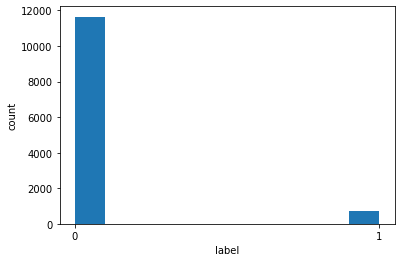

In [ ]:
count_labels(twitter_hatespeech_strict.train_y)

Count of hatespeech is: 243
Count of non-hatespeech is: 1797
Percentage of hatespeech is: 0.11911764705882352


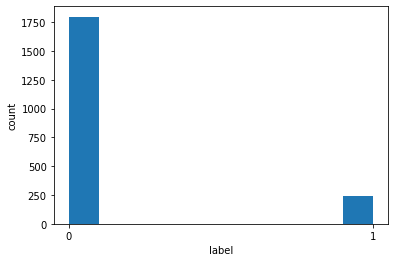

In [ ]:
count_labels(political.train_y)

In [ ]:
!pip3 install textattack

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 418 kB 14.5 MB/s 
     |████████████████████████████████| 41.4 MB 243 kB/s 
     |████████████████████████████████| 365 kB 77.1 MB/s 
     |████████████████████████████████| 401 kB 76.4 MB/s 
     |████████████████████████████████| 769 kB 75.3 MB/s 
     |████████████████████████████████| 5.8 MB 63.0 MB/s 
     |████████████████████████████████| 3.6 MB 76.3 MB/s 
     |████████████████████████████████| 125 kB 62.5 MB/s 
     |████████████████████████████████| 60 kB 8.8 MB/s 
     |████████████████████████████████| 132 kB 16.4 MB/s 
     |████████████████████████████████| 95 kB 6.3 MB/s 
     |████████████████████████████████| 182 kB 70.7 MB/s 
     |████████████████████████████████| 212 kB 58.9 MB/s 
     |████████████████████████████████| 127 kB 62.1 MB/s 
     |████████████████████████████████| 7.6 MB 1.5 MB/s 
     |██████████████████████████████

In [ ]:
def augment_text(dataset, augmenters, undersample = None, aug_frac = None, pct_of_majority = None):
    train_x = dataset.train_x
    train_y = dataset.train_y

    # get class counts to determine the minority class
    unique, counts = np.unique(train_y, return_counts=True)
    class_counts = dict(zip(unique, counts))
    print(f'the pre-augmented class counts are: {class_counts}')
    # minority_class = [key for key in class_counts if class_counts[key] == min(class_counts.values())]
    # majority_class = [key for key in class_counts if class_counts[key] == min(class_counts.values())]
    majority_class = max(class_counts.keys(), key=(lambda k: class_counts[k]))
    minority_class = min(class_counts.keys(), key=(lambda k: class_counts[k]))
    # We generate a number of examples per sentence, rounded down, to bring the minority up to the designated
    # proportion of the majority


    if undersample is not None:
        undersample = RandomUnderSampler(sampling_strategy={majority_class:undersample,minority_class:class_counts[minority_class]})
        train_x, train_y = undersample.fit_resample(train_x, train_y)
        
        unique, counts = np.unique(train_y, return_counts=True)
        class_counts = dict(zip(unique, counts))
        print(f'the undersampled class counts are: {class_counts}')

    train_df = pd.DataFrame({'x':train_x.squeeze(), 'y':train_y.squeeze()})

    if pct_of_majority is not None:
        aug_scale = int(math.floor((class_counts[majority_class]/class_counts[minority_class])*pct_of_majority)/len(augmenters))
        for augmenter in augmenters:
            augmenter.transformations_per_example = aug_scale

    samples_to_aug = train_df[train_df['y'].astype(int) == int(minority_class)]

    if aug_frac is not None:
        samples_to_aug = samples_to_aug.sample(n= round(class_counts[minority_class]*aug_frac))
 
    samples_to_aug_x = samples_to_aug['x'].to_numpy()
    samples_to_aug_y = samples_to_aug['y'].to_numpy()

    aug_x = []
    aug_y = []

    for augmenter in augmenters:
        for text, label in zip(samples_to_aug_x, samples_to_aug_y):

            aug_list = augmenter.augment(str(text))

            aug_x.extend(aug_list)

            aug_y.extend([label]*len(aug_list))
    
    aug_x = np.array(aug_x)
    aug_y = np.array(aug_y)

    final_x = np.concatenate((train_x.squeeze(), aug_x), axis=0)
    final_y = np.concatenate((train_y.squeeze(), aug_y), axis=0)
    
    unique, counts = np.unique(final_y, return_counts=True)
    class_counts = dict(zip(unique, counts))
    print(f'the post-augmented class counts are: {class_counts}')

    dataset.train_x = np.expand_dims(final_x, axis=1)
    dataset.train_y = final_y
    return dataset


In [ ]:
from textattack.augmentation import EmbeddingAugmenter
from textattack.augmentation import EasyDataAugmenter
from textattack.augmentation import CheckListAugmenter
from textattack.augmentation import WordNetAugmenter

In [ ]:
twitter_loose_aug = DatasetTwitter("data/twitter-hatespeech/with_offensive_language")
twitter_strict_aug = DatasetTwitter("data/twitter-hatespeech/without_offensive_language")
reddit_aug = DatasetReddit("data/reddit-abusive-comments")
political_aug = DatasetPolitical("data/political-twitter-hatespeech")
wikipedia_aug = DatasetWikipedia("data/wikipedia-toxic-comments")

In [ ]:
emb_aug = EmbeddingAugmenter(pct_words_to_swap=0.1, transformations_per_example=4)
ed_aug = EasyDataAugmenter(pct_words_to_swap=0.1, transformations_per_example=4)
check_aug = CheckListAugmenter(pct_words_to_swap=0.1, transformations_per_example=3)
wordnet_aug = WordNetAugmenter(pct_words_to_swap=0.1, transformations_per_example=4)

aug_list = [emb_aug, ed_aug, check_aug, wordnet_aug]
#aug_list = [emb_aug]
twitter_loose_aug = augment_text(twitter_loose_aug, aug_list, undersample = None, aug_frac = None, pct_of_majority = 1)
twitter_strict_aug = augment_text(twitter_strict_aug, aug_list, undersample = None, aug_frac = None, pct_of_majority = 1)
political_aug = augment_text(political_aug, aug_list, undersample = None, aug_frac = None, pct_of_majority = 1)


textattack: Downloading https://textattack.s3.amazonaws.com/word_embeddings/paragramcf.
100%|██████████| 481M/481M [00:17<00:00, 27.5MB/s]
textattack: Unzipping file /root/.cache/textattack/tmpemne21ck.zip to /root/.cache/textattack/word_embeddings/paragramcf.
textattack: Successfully saved word_embeddings/paragramcf to cache.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


the pre-augmented class counts are: {0: 2091, 1: 10300}
the post-augmented class counts are: {0: 10455, 1: 10300}
the pre-augmented class counts are: {0: 11648, 1: 743}
the post-augmented class counts are: {0: 11648, 1: 8493}
the pre-augmented class counts are: {0: 1797, 1: 243}
the post-augmented class counts are: {0: 1797, 1: 1215}


In [ ]:
MNB = MultinomialNB()
fit_classifier(twitter_strict_aug,
                     MNB, 
                     dataset_name= 'Augmented Twitter Hatespeech (without offensive language)',
                     classifier_name = 'Multinomial Naive Bayes',
                     twitter_tokens = True,
                     return_classifier = False)

fit_classifier(twitter_loose_aug,
                     MNB, 
                     dataset_name= 'Augmented Twitter Hatespeech (with offensive language)',
                     classifier_name = 'Multinomial Naive Bayes',
                     twitter_tokens = True,
                     return_classifier = False)

fit_classifier(political_aug,
                     MNB, 
                     dataset_name= 'Augmented Political',
                     classifier_name = 'Multinomial Naive Bayes',
                     twitter_tokens = True,
                     return_classifier = False)



Augmented Twitter Hatespeech (without offensive language)
Multinomial Naive Bayes
accuracy: 0.9176888315041962
precision: 0.31413612565445026
sensitivity: 0.32608695652173914
specificity: 0.955044612216884
f1: 0.32



In [ ]:
#twitter strict dataset
twitter_train_strict_tokens = get_tokenized(twitter_strict_aug.train_x)
twitter_dev_strict_tokens = get_tokenized(twitter_strict_aug.dev_x)
vocab_to_id_twitter_strict = get_vocab_to_id(twitter_train_strict_tokens)
train_twitter_strict_feature = get_features(twitter_train_strict_tokens, vocab_to_id_twitter_strict)
dev_twitter_strict_feature = get_features(twitter_dev_strict_tokens, vocab_to_id_twitter_strict)

epochs = 5
n_embed = len(vocab_to_id_twitter_strict) + 1
model = LSTM(vocab_size=n_embed,embed_size=d_embed,hidden_size=128,out_size=d_out)
train(model,train_twitter_strict_feature, twitter_strict_aug.train_y, dev_twitter_strict_feature, twitter_strict_aug.dev_y, lr, batch_size,weight_decay)

epoch |   %        |  loss  |  avg   |val loss|   acc   |  best  | time | save |
val   |            |        |        | 0.7139 | 9.7321 | 9.7321 |      |      |
    4 | 20160/20141 | 0.3666 | 0.4212 |Dev metrics
LSTM
accuracy: 0.9406068431245965
precision: 0.0
sensitivity: 0.0
specificity: 1.0
f1: 0.0


Dev Accuracy :  94.06068431245966 
Dev Loss :  0.48679462 
Dev ROC_AUC score :  0.5 
Dev F1 score : 0.0


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
political_train_tokens = get_tokenized(political_aug.train_x)
political_dev_tokens = get_tokenized(political_aug.dev_x)

vocab_to_id_political = get_vocab_to_id(political_train_tokens)
train_political_feature = get_features(political_train_tokens, vocab_to_id_political)
dev_political_feature = get_features(political_dev_tokens, vocab_to_id_political)

epochs = 5
n_embed = len(vocab_to_id_political) + 1
model = LSTM(vocab_size=n_embed,embed_size=d_embed,hidden_size=128,out_size=d_out)
train(model,train_political_feature, political_aug.train_y, dev_political_feature, political_aug.dev_y, lr, batch_size, weight_decay)

epoch |   %        |  loss  |  avg   |val loss|   acc   |  best  | time | save |
val   |            |        |        | 0.8201 | 11.1111 | 11.1111 |      |      |
    4 | 3040/3012 | 0.5246 | 0.5738 |Dev metrics
LSTM
accuracy: 0.4083333333333333
precision: 0.10091743119266056
sensitivity: 0.5641025641025641
specificity: 0.3894080996884735
f1: 0.17120622568093385


Dev Accuracy :  40.833333333333336 
Dev Loss :  0.6783841 
Dev ROC_AUC score :  0.4767553318955188 
Dev F1 score : 0.17120622568093385


## Naive Bayes cross-domain

In [ ]:
import itertools

def do_MultinomialNB_cross(training_dataset, evaluation_datasets, training_dataset_name: str, evaluation_dataset_names: str, training_twitter_tokens = False, evaluation_twitter_tokenses = itertools.repeat(False), return_classifier = True):
    classifier = MultinomialNB()

    training_feature, *evaluation_features = tfidf_representation(training_dataset, training_twitter_tokens, evaluation_datasets, evaluation_twitter_tokenses)
    t_X_train, t_X_test, t_X_dev = training_feature
    t_y_train = training_dataset.train_y
    classifier.fit(t_X_train, t_y_train)

    t_y_pred = classifier.predict(t_X_test)
    t_y_true = training_dataset.test_y
    print_metrics(t_y_pred, t_y_true, f"Naive Bayes (trained on {training_dataset_name})", f"Evaluated on {training_dataset_name}")

    for evaluation_dataset, evaluation_feature, evaluation_dataset_name, evaluation_twitter_tokens in zip(evaluation_datasets, evaluation_features, evaluation_dataset_names, evaluation_twitter_tokenses):
        e_X_train, e_X_test, e_X_dev = evaluation_feature
        e_y_pred = classifier.predict(e_X_test)
        e_y_true = evaluation_dataset.test_y

        print_metrics(e_y_pred, e_y_true, f"Naive Bayes (trained on {training_dataset_name})", f"Evaluated on {evaluation_dataset_name}")

    if return_classifier:
        return classifier

In [ ]:
do_MultinomialNB_cross(twitter_hatespeech_loose, [political], 
                       "twitter_hatespeech_loose", ["political"], 
                       True, [True])

Evaluated on twitter_hatespeech_loose
Naive Bayes (trained on twitter_hatespeech_loose)
accuracy: 0.8439315687540349
precision: 0.8421826498938082
sensitivity: 0.9998060512024826
specificity: 0.07115384615384615
f1: 0.9142502438591823
TP: 5155, FP: 966
TN: 74, FN: 1

Evaluated on political
Naive Bayes (trained on twitter_hatespeech_loose)
accuracy: 0.09833333333333333
precision: 0.09833333333333333
sensitivity: 1.0
specificity: 0.0
f1: 0.17905918057663123
TP: 59, FP: 541
TN: 0, FN: 0



MultinomialNB()

In [ ]:
do_MultinomialNB_cross(twitter_hatespeech_strict, [political], 
                       "twitter_hatespeech_strict", ["political"], 
                       True, [True])

Evaluated on twitter_hatespeech_strict
Naive Bayes (trained on twitter_hatespeech_strict)
accuracy: 0.9485151710781149
precision: nan
sensitivity: 0.0
specificity: 1.0
f1: nan
TP: 0, FP: 0
TN: 5877, FN: 319

Evaluated on political
Naive Bayes (trained on twitter_hatespeech_strict)
accuracy: 0.9016666666666666
precision: nan
sensitivity: 0.0
specificity: 1.0
f1: nan
TP: 0, FP: 0
TN: 541, FN: 59



MultinomialNB()

In [ ]:
do_MultinomialNB_cross(political, [twitter_hatespeech_loose, twitter_hatespeech_strict], 
                       "political", ["twitter_hatespeech_loose", "twitter_hatespeech_strict"], 
                       True, [True, True])

Evaluated on political
Naive Bayes (trained on political)
accuracy: 0.9016666666666666
precision: nan
sensitivity: 0.0
specificity: 1.0
f1: nan
TP: 0, FP: 0
TN: 541, FN: 59

Evaluated on twitter_hatespeech_loose
Naive Bayes (trained on political)
accuracy: 0.16785022595222723
precision: nan
sensitivity: 0.0
specificity: 1.0
f1: nan
TP: 0, FP: 0
TN: 1040, FN: 5156

Evaluated on twitter_hatespeech_strict
Naive Bayes (trained on political)
accuracy: 0.9485151710781149
precision: nan
sensitivity: 0.0
specificity: 1.0
f1: nan
TP: 0, FP: 0
TN: 5877, FN: 319



MultinomialNB()

## BERT

### Setup

In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
import time

import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import ModelCheckpoint

tf.get_logger().setLevel('ERROR')

In [ ]:
#######3333itrrrrrrrrrrrrrrttttttt#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-8_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
class_names = ["Not Problematic", "Problematic"]
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32


def create_keras_dataset(dataset):
    def create_keras_dataset_single(X, y):
        ds = tf.data.Dataset.from_tensor_slices((as_1d(X), as_1d(y)))
        ds = ds.batch(batch_size)
        ds = ds.cache().prefetch(buffer_size=AUTOTUNE)
        return ds
    train_ds = create_keras_dataset_single(dataset.train_x, dataset.train_y)
    dev_ds = create_keras_dataset_single(dataset.dev_x, dataset.dev_y)
    test_ds = create_keras_dataset_single(dataset.test_x, dataset.test_y)
    return train_ds, dev_ds, test_ds

In [ ]:
def build_classifier_model(dropout = 0.3):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(dropout)(net)
    net = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [ ]:
import keras.backend as K

# Macro f1 loss: https://www.kaggle.com/code/rejpalcz/best-loss-function-for-f1-score-metric/notebook#Optimal-loss-function---macro-F1-score
def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(K.cast(y_true, 'float')*K.cast(y_pred, 'float'), 'float'), axis=0)
    tn = K.sum(K.cast(K.cast((1-y_true), 'float')*K.cast((1-y_pred), 'float'), 'float'), axis=0)
    fp = K.sum(K.cast(K.cast((1-y_true), 'float')*K.cast(y_pred, 'float'), 'float'), axis=0)
    fn = K.sum(K.cast(K.cast(y_true, 'float')*K.cast((1-y_pred), 'float'), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)


metric_names = [
    "f1_score",
    "binary_accuracy"
]

def get_metric_functions():
    return [
        tfa.metrics.F1Score(num_classes=2, threshold=0.5, average="micro"),
        tf.keras.metrics.BinaryAccuracy(),
    ]

def get_loss_function():
    return f1_loss
    # return tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [ ]:
def create_optimizer(lr, num_train_steps = 100, num_warmup_steps = 10):
    return optimization.create_optimizer(init_lr=lr,
                                        num_train_steps=num_train_steps,
                                        num_warmup_steps=num_warmup_steps,
                                        optimizer_type='adamw')

def create_and_train_bert(training_dataset, *, dropout, lr, return_metrics = False, default_epochs = None):
    training_dataset_name = str(training_dataset)
    training_ds_tuple = create_keras_dataset(training_dataset)
    train_ds, val_ds, test_ds = training_ds_tuple

    classifier_model = build_classifier_model(dropout)
    tf.keras.utils.plot_model(classifier_model)

    loss_fn = get_loss_function()
    metric_fns = get_metric_functions()


    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
    if default_epochs is None:
        if steps_per_epoch < 100:
            init_epochs = 10
        else:
            init_epochs = 5
    else:
        init_epochs = default_epochs
    num_train_steps = steps_per_epoch * init_epochs
    num_warmup_steps = int(0.1*num_train_steps)

    optimizer = create_optimizer(lr, num_train_steps, num_warmup_steps)
    
    #### TRAINING #####

    classifier_model.compile(optimizer=optimizer,
                    loss=loss_fn,
                    metrics=metric_fns)
    

    checkpointer = ModelCheckpoint(filepath="weights.hdf5", monitor="val_f1_score", mode='max', verbose=1, save_weights_only=True, save_best_only=True)

    print(f'Training model with {tfhub_handle_encoder}')
    history = classifier_model.fit(x=train_ds,
                                validation_data=val_ds,
                                epochs=init_epochs,
                                callbacks=[checkpointer])
    classifier_model.load_weights('weights.hdf5')
    
    #### VALIDATION ####
    loss, *metrics = classifier_model.evaluate(val_ds)

    print(f'loss: {loss}')
    for metric, metric_name in zip(metrics, metric_names):
        print(f'{metric_name}: {metric}')

    y_pred = (classifier_model.predict(val_ds)) > 0.5
    y_true = training_dataset.dev_y
    print_metrics(y_pred, y_true, f"BERT (trained on {training_dataset})", f"Validating on {training_dataset} (dev)")

    history_dict = history.history

    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    num_epochs = len(loss)
    num_rows = len(metric_names) + 1
    epochs = range(1, num_epochs + 1)
    fig = plt.figure(figsize=(10, 5 * num_rows))
    # fig.tight_layout()

    plt.subplot(num_rows, 1, 1)
    # r is for "solid red line"
    plt.plot(epochs, loss, 'r', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'Training and validation loss')
    # plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    for i, metric_name in enumerate(metric_names):
        print(metric_name)
        metric = history_dict[metric_name]
        print("Train:", metric)
        val_metric = history_dict[f'val_{metric_name}']
        print("Validation:", val_metric)

        plt.subplot(num_rows, 1, i + 2)
        plt.plot(epochs, metric, 'r', label=f'Training {metric_name}')
        plt.plot(epochs, val_metric, 'b', label=f'Validation {metric_name}')
        plt.title(f'Training and validation {metric_name}')
        plt.xlabel('Epochs')
        plt.ylabel(metric_name)
        plt.legend(loc='best')

    if return_metrics:
        return classifier_model, metrics
    else:
        return classifier_model

In [ ]:
def evaluate_bert(classifier_model, evaluate_dataset, *, return_metrics = False, training_dataset_name = "Not specified"):
    evaluate_dataset_name = str(evaluate_dataset)
    eval_ds_tuple = create_keras_dataset(evaluate_dataset)
    eval_train_ds, eval_dev_ds, eval_test_ds = eval_ds_tuple

    if return_metrics:
        loss, *metrics = classifier_model.evaluate(eval_test_ds)

        print(f'loss: {loss}')
        for metric, metric_name in zip(metrics, metric_names):
            print(f'{metric_name}: {metric}')
    

    y_pred = (classifier_model.predict(eval_test_ds)) > 0.5
    y_true = evaluate_dataset.test_y
    x_true = evaluate_dataset.test_x

    print_metrics(y_pred, y_true, f"BERT (trained on {training_dataset_name})", f"Evaluating on {evaluate_dataset} (test)")

    if return_metrics:
        return metrics, y_pred, y_true, x_true
    else:
        return y_pred, y_true, x_true

In [ ]:
def run_bert(training_dataset, evaluation_datasets, *, dropout, lr):
    classifier_model = create_and_train_bert(training_dataset, dropout = dropout, lr = lr)
    for evaluate_dataset in evaluation_datasets:
        evaluate_bert(classifier_model, evaluate_dataset, training_dataset_name = str(training_dataset))
    return classifier_model

In [ ]:
def tune_and_run_bert(training_dataset, evaluation_datasets, *, dropouts, lrs):
    val_f1s = pd.DataFrame(columns = ['Dropout', 'Lr', 'F1'])
    best_val_f1 = -1
    best_dropout = 0
    best_lr = 0

    for d in dropouts:
        for lr in lrs:
            print(f'\n#### DROPOUT: {d}, INIT_LR: {lr} ####\n')
            
            classifier_model, metrics = create_and_train_bert(training_dataset, dropout = d, lr = lr, return_metrics = True)

            f1 = metrics[0]
            print(f"{type(f1)}")
            stats = pd.DataFrame.from_dict({'Dropout':[d], 'Lr':[lr], 'F1':[f1]})
            val_f1s = pd.concat([val_f1s,stats])

            trained_model_path = f"./saved_bert_{str(training_dataset)}_{time.strftime('%Y%m%d-%H%M%S')}"

            if f1 >= best_val_f1:
                best_val_f1 = f1
                best_dropout = d
                best_lr = lr

                classifier_model.save(trained_model_path, include_optimizer=False)
                final_model = tf.keras.models.load_model(trained_model_path)
                final_model.compile(optimizer=create_optimizer(lr),
                loss=get_loss_function(),
                metrics=get_metric_functions())

            
            # Evaluate individual combinations for debugging
            for evaluate_dataset in evaluation_datasets:
                y_pred, y_true, x_true = evaluate_bert(classifier_model, evaluate_dataset, training_dataset_name = f"{training_dataset} (lr = {lr}, dropout = {d})")
    print(f'Best combination is dropout of {best_dropout} and lr of {best_lr}, resulting in val f1 of {best_val_f1}')

    #### EVALUATION OF BEST MODEL####
    for evaluate_dataset in evaluation_datasets:
        evaluate_bert(final_model, evaluate_dataset, training_dataset_name = str(training_dataset))

    return final_model, val_f1s, y_pred, y_true, x_true


### Run Model

#### DROPOUT: 0.2, INIT_LR: 1e-05 ####
Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Epoch 1/5
388/388 [==============================] - ETA: 0s - loss: 0.2913 - f1_score: 0.9067 - binary_accuracy: 0.8468
Epoch 1: val_f1_score improved from -inf to 0.96631, saving model to weights.hdf5
388/388 [==============================] - 173s 415ms/step - loss: 0.2913 - f1_score: 0.9067 - binary_accuracy: 0.8468 - val_loss: 0.1399 - val_f1_score: 0.9663 - val_binary_accuracy: 0.9446
Epoch 2/5
388/388 [==============================] - ETA: 0s - loss: 0.1252 - f1_score: 0.9695 - binary_accuracy: 0.9500
Epoch 2: val_f1_score improved from 0.96631 to 0.97203, saving model to weights.hdf5
388/388 [==============================] - 162s 418ms/step - loss: 0.1252 - f1_score: 0.9695 - binary_accuracy: 0.9500 - val_loss: 0.1278 - val_f1_score: 0.9720 - val_binary_accuracy: 0.9538
Epoch 3/5
388/388 [==============================] - ETA: 0s - loss: 0.1007 - 

#### DROPOUT: 0.2, INIT_LR: 0.001 ####
Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Epoch 1/5
388/388 [==============================] - ETA: 0s - loss: 0.4046 - f1_score: 0.9305 - binary_accuracy: 0.8810
Epoch 1: val_f1_score improved from -inf to 0.90915, saving model to weights.hdf5
388/388 [==============================] - 169s 420ms/step - loss: 0.4046 - f1_score: 0.9305 - binary_accuracy: 0.8810 - val_loss: 0.4510 - val_f1_score: 0.9092 - val_binary_accuracy: 0.8334
Epoch 2/5
388/388 [==============================] - ETA: 0s - loss: 0.4798 - f1_score: 0.8987 - binary_accuracy: 0.8167
Epoch 2: val_f1_score did not improve from 0.90915
388/388 [==============================] - 162s 418ms/step - loss: 0.4798 - f1_score: 0.8987 - binary_accuracy: 0.8167 - val_loss: 0.4563 - val_f1_score: 0.9092 - val_binary_accuracy: 0.8334
Epoch 3/5
388/388 [==============================] - ETA: 0s - loss: 0.4721 - f1_score: 0.9045 - binary_accuracy

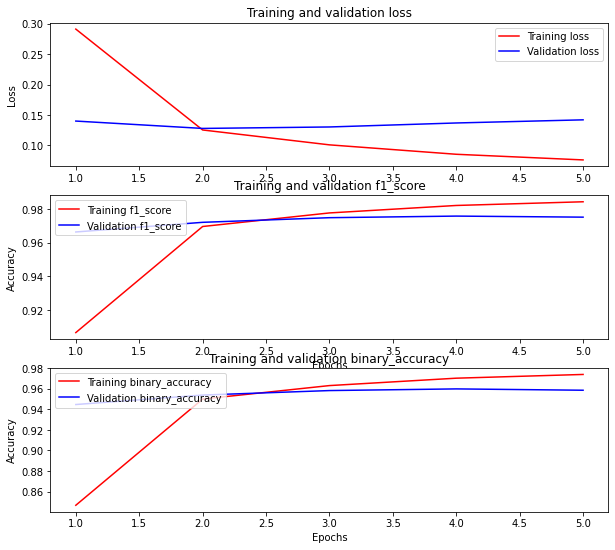

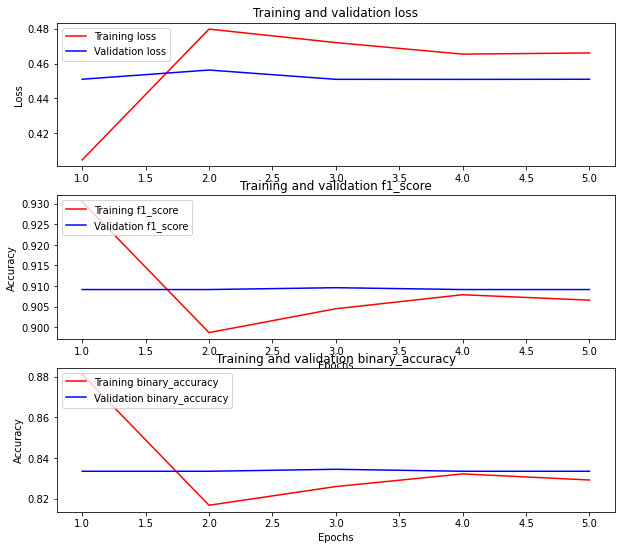

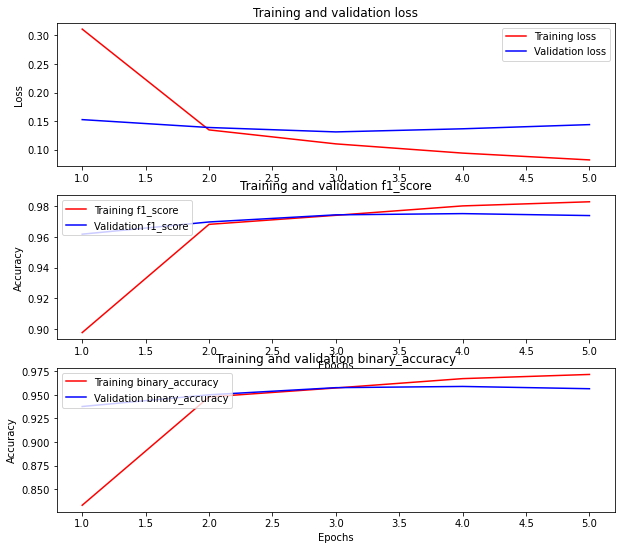

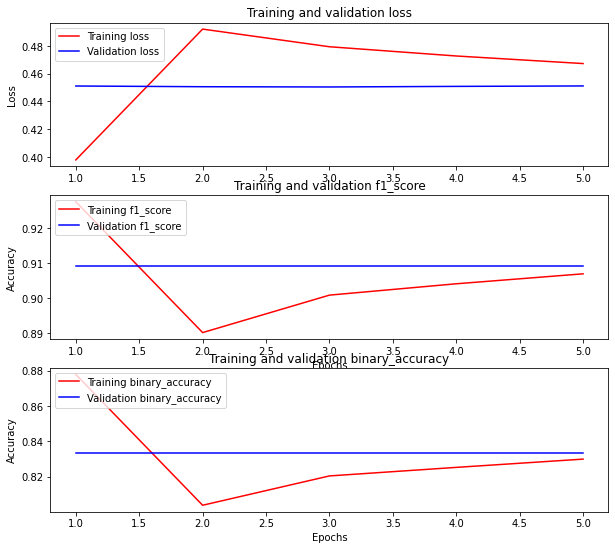

In [ ]:
dropouts = [.2,.4]
lrs = [1e-5, 1e-3]

evluation_datasets = [
    twitter_hatespeech_loose,
    twitter_hatespeech_strict,
    political,
    reddit,
    wikipedia
]

training_dataset = twitter_hatespeech_loose

model, stats, y_pred, y_true, x_true = tune_and_run_bert(training_dataset, evluation_datasets, dropouts = dropouts, lrs = lrs)


# All Datasets Experiment

### Twitter Loose & Political & Wikipedia | Reddit

In [ ]:
temp = np.append(twitter_hatespeech_loose.train_x, political.train_x)
loose_political_wikipedia_train_x = np.append(temp, wikipedia.train_x)

temp = np.append(twitter_hatespeech_loose.train_y, political.train_y)
loose_political_wikipedia_train_y = np.append(temp, wikipedia.train_y)

temp = np.append(twitter_hatespeech_loose.dev_x, political.dev_x)
loose_political_wikipedia_dev_x = np.append(temp, wikipedia.dev_x)

temp = np.append(twitter_hatespeech_loose.dev_y, political.dev_y)
loose_political_wikipedia_dev_y = np.append(temp, wikipedia.dev_y)

temp = np.append(twitter_hatespeech_loose.test_x, political.test_x)
loose_political_wikipedia_test_x = np.append(temp, wikipedia.test_x)

temp = np.append(twitter_hatespeech_loose.test_y, political.test_y)
loose_political_wikipedia_test_y = np.append(temp, wikipedia.test_y)

### Twitter Loose & Political & Reddit | Wikipedia

In [ ]:
temp = np.append(twitter_hatespeech_loose.train_x, political.train_x)
loose_political_reddit_train_x = np.append(temp, reddit.train_x)

temp = np.append(twitter_hatespeech_loose.train_y, political.train_y)
loose_political_reddit_train_y = np.append(temp, reddit.train_y)

temp = np.append(twitter_hatespeech_loose.dev_x, political.dev_x)
loose_political_reddit_dev_x = np.append(temp, reddit.dev_x)

temp = np.append(twitter_hatespeech_loose.dev_y, political.dev_y)
loose_political_reddit_dev_y = np.append(temp, reddit.dev_y)

temp = np.append(twitter_hatespeech_loose.test_x, political.test_x)
loose_political_reddit_test_x = np.append(temp, reddit.test_x)

temp = np.append(twitter_hatespeech_loose.test_y, political.test_y)
loose_political_reddit_test_y = np.append(temp, reddit.test_y)

### Twitter Loose & Wikipedia & Reddit | Political

In [ ]:
temp = np.append(twitter_hatespeech_loose.train_x, wikipedia.train_x)
loose_wikipedia_reddit_train_x = np.append(temp, reddit.train_x)

temp = np.append(twitter_hatespeech_loose.train_y, wikipedia.train_y)
loose_wikipedia_reddit_train_y = np.append(temp, reddit.train_y)

temp = np.append(twitter_hatespeech_loose.dev_x, wikipedia.dev_x)
loose_wikipedia_reddit_dev_x = np.append(temp, reddit.dev_x)

temp = np.append(twitter_hatespeech_loose.dev_y, wikipedia.dev_y)
loose_wikipedia_reddit_dev_y = np.append(temp, reddit.dev_y)

temp = np.append(twitter_hatespeech_loose.test_x, wikipedia.test_x)
loose_wikipedia_reddit_test_x = np.append(temp, reddit.test_x)

temp = np.append(twitter_hatespeech_loose.test_y, wikipedia.test_y)
loose_wikipedia_reddit_test_y = np.append(temp, reddit.test_y)

### Political & Wikipedia & Reddit | Twitter Loose

In [ ]:
temp = np.append(political.train_x, wikipedia.train_x)
political_wikipedia_reddit_train_x = np.append(temp, reddit.train_x)

temp = np.append(political.train_y, wikipedia.train_y)
political_wikipedia_reddit_train_y = np.append(temp, reddit.train_y)

temp = np.append(political.dev_x, wikipedia.dev_x)
political_wikipedia_reddit_dev_x = np.append(temp, reddit.dev_x)

temp = np.append(political.dev_y, wikipedia.dev_y)
political_wikipedia_reddit_dev_y = np.append(temp, reddit.dev_y)

temp = np.append(political.test_x, wikipedia.test_x)
political_wikipedia_reddit_test_x = np.append(temp, reddit.test_x)

temp = np.append(political.test_y, wikipedia.test_y)
political_wikipedia_reddit_test_y = np.append(temp, reddit.test_y)

In [ ]:
print(len(reddit.train_x))

13584


# Under/Oversampling Experiments

These experiments are designed to under/oversample certain datasets to equalize the effect of certain training sets being far larger.

In [ ]:
def undersample(dataset, class_0_train_count, class_1_train_count, class_0_val_count, class_1_val_count):
    train_undersample = RandomUnderSampler(sampling_strategy={0:class_0_train_count,1:class_1_train_count})
    dataset.train_x, dataset.train_y = train_undersample.fit_resample(dataset.train_x, dataset.train_y)

    val_undersample = RandomUnderSampler(sampling_strategy={0:class_0_val_count,1:class_1_val_count})
    dataset.dev_x, dataset.dev_y = val_undersample.fit_resample(dataset.dev_x, dataset.dev_y)
    
    unique, counts = np.unique(dataset.train_y, return_counts=True)
    class_counts = dict(zip(unique, counts))
    print(f'the undersampled class counts are: {class_counts}')

    return dataset

def oversample(dataset, class_0_train_count, class_1_train_count, class_0_val_count, class_1_val_count):
    train_oversample = RandomOverSampler(sampling_strategy={0:class_0_train_count,1:class_1_train_count})
    dataset.train_x, dataset.train_y = train_oversample.fit_resample(dataset.train_x, dataset.train_y)

    val_oversample = RandomOverSampler(sampling_strategy={0:class_0_val_count,1:class_1_val_count})
    dataset.dev_x, dataset.dev_y = val_oversample.fit_resample(dataset.dev_x, dataset.dev_y)
    
    unique, counts = np.unique(dataset.train_y, return_counts=True)
    class_counts = dict(zip(unique, counts))
    print(f'the oversampled class counts are: {class_counts}')

    return dataset

Let's get another look at some dataset counts

Count of hatespeech is: 243
Count of non-hatespeech is: 1797
Percentage of hatespeech is: 0.11911764705882352


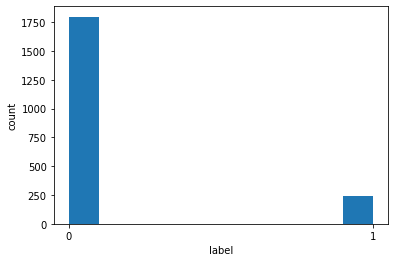

In [ ]:
count_labels(political.train_y)

Count of hatespeech is: 39
Count of non-hatespeech is: 321
Percentage of hatespeech is: 0.10833333333333334


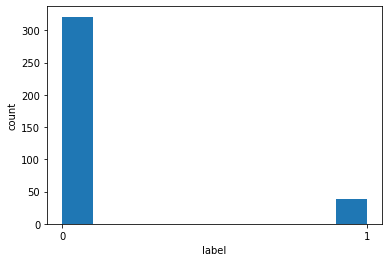

In [ ]:
count_labels(political.dev_y)

Count of hatespeech is: 10300
Count of non-hatespeech is: 2091
Percentage of hatespeech is: 0.8312484868049391


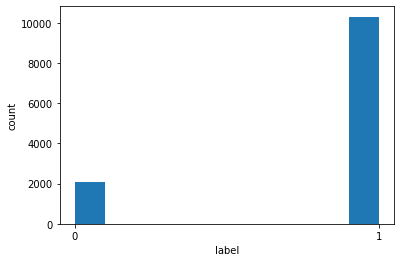

In [ ]:
count_labels(twitter_hatespeech_loose.train_y)

Count of hatespeech is: 5164
Count of non-hatespeech is: 1032
Percentage of hatespeech is: 0.8334409296320207


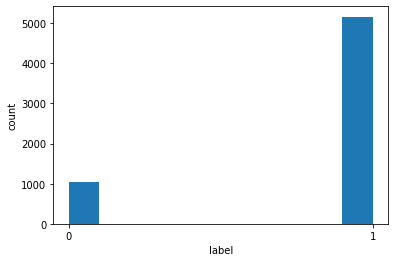

In [ ]:
count_labels(twitter_hatespeech_loose.dev_y)

In [ ]:
twitter_loose_under = undersample(twitter_hatespeech_loose, 1797, 243, 321, 39)

the undersampled class counts are: {0: 1797, 1: 243}


Count of hatespeech is: 3245
Count of non-hatespeech is: 28670
Percentage of hatespeech is: 0.10167632774557418


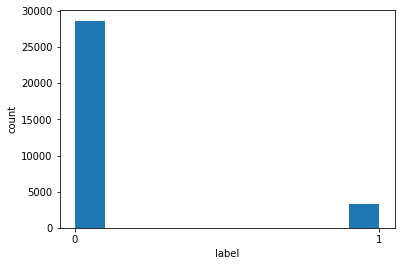

In [ ]:
count_labels(wikipedia.dev_y)

In [ ]:
political_over = oversample(political, 2091, 10300, 1032, 5164)

the oversampled class counts are: {0: 2091, 1: 10300}


/usr/local/lib/python3.8/dist-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (2091) in class 0 will be larger than the number of samples in the majority class (class #0 -> 1797)
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (10300) in class 1 will be larger than the number of samples in the majority class (class #0 -> 1797)
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (1032) in class 0 will be larger than the number of samples in the majority class (class #0 -> 321)
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (5164) in class 1 will be larger than the number of samples in the majority class (class #0 -> 321)
  warnings.warn(


In [ ]:
wikipedia_under = undersample(wikipedia, 2091, 10300, 1032, 3245)

the undersampled class counts are: {0: 2091, 1: 10300}



#### DROPOUT: 0.2, INIT_LR: 1e-05 ####

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Epoch 1/10
64/64 [==============================] - ETA: 0s - loss: 0.9744 - f1_score: 0.0000e+00 - binary_accuracy: 0.6554
Epoch 1: val_f1_score improved from -inf to 0.00000, saving model to weights.hdf5
64/64 [==============================] - 42s 420ms/step - loss: 0.9744 - f1_score: 0.0000e+00 - binary_accuracy: 0.6554 - val_loss: 0.4624 - val_f1_score: 0.0000e+00 - val_binary_accuracy: 0.8917
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 0.7697 - f1_score: 0.0000e+00 - binary_accuracy: 0.8809
Epoch 2: val_f1_score did not improve from 0.00000
64/64 [==============================] - 25s 394ms/step - loss: 0.7697 - f1_score: 0.0000e+00 - binary_accuracy: 0.8809 - val_loss: 0.6090 - val_f1_score: 0.0000e+00 - val_binary_accuracy: 0.8917
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 0.6937 - f1_score: 0.0000e

194/194 [==============================] - 29s 148ms/step - loss: 2.2084 - f1_score: 0.3189 - binary_accuracy: 0.3257
loss: 2.208369255065918
f1_score: 0.3188783824443817
binary_accuracy: 0.3256939947605133
194/194 [==============================] - 28s 144ms/step
Evaluating on twitter_loose (test)
BERT (trained on twitter_loose)
accuracy: 0.32569399612653327
precision: 1.0
sensitivity: 0.18968192397207137
specificity: 1.0
f1: 0.31887838278447994
TP: 978, FP: 0
TN: 1040, FN: 4178

194/194 [==============================] - 28s 146ms/step - loss: 0.4705 - f1_score: 0.0617 - binary_accuracy: 0.8036
loss: 0.47053372859954834
f1_score: 0.06168079748749733
binary_accuracy: 0.8035829663276672
194/194 [==============================] - 28s 143ms/step
Evaluating on twitter_strict (test)
BERT (trained on twitter_loose)
accuracy: 0.8035829567462879
precision: 0.0408997955010225
sensitivity: 0.12539184952978055
specificity: 0.8403947592309001
f1: 0.06168080185042406
TP: 40, FP: 938
TN: 4939, FN: 

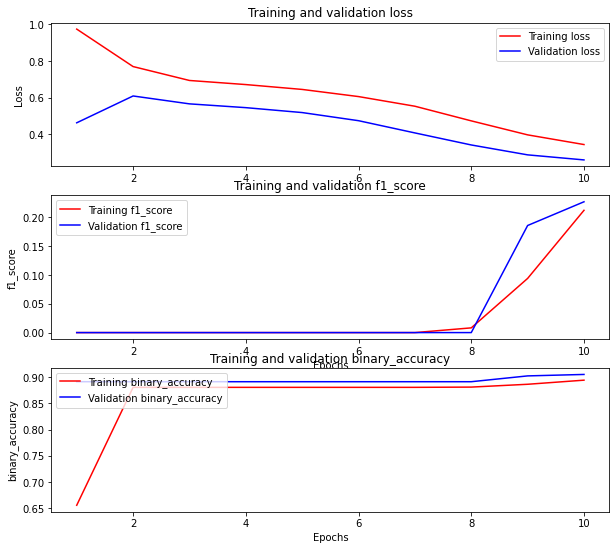

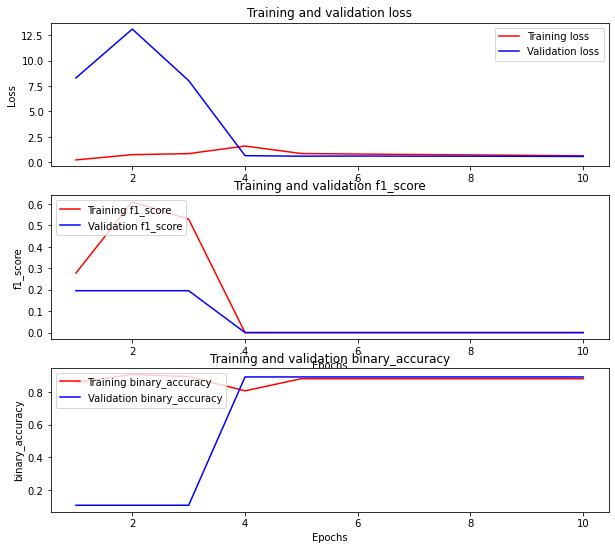

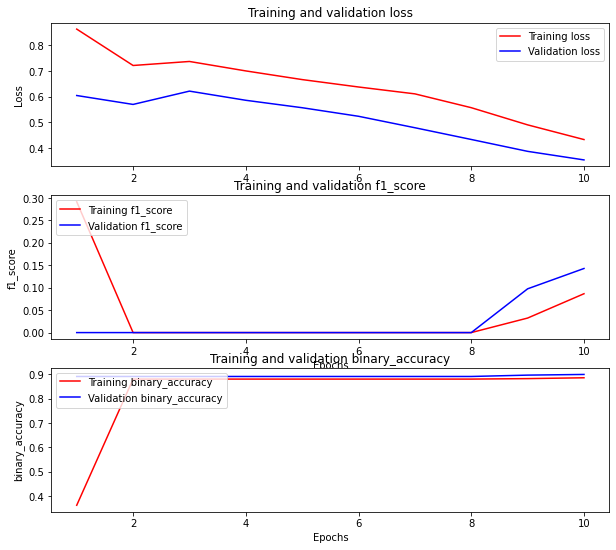

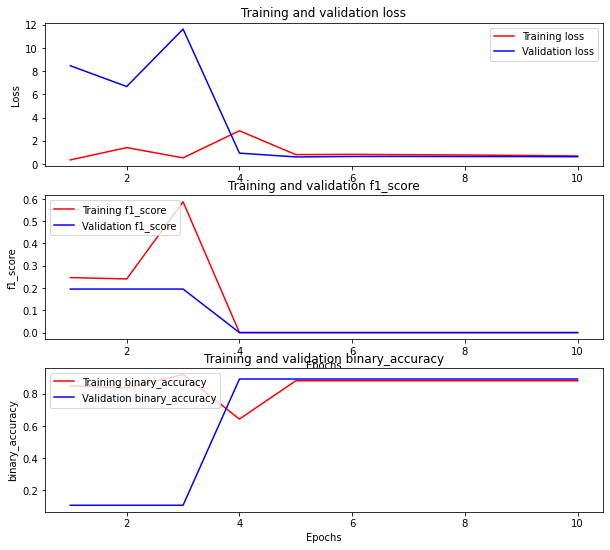

In [ ]:
dropouts = [.2,.4]
lrs = [1e-5, 1e-3]

evluation_datasets = [
    twitter_hatespeech_loose,
    twitter_hatespeech_strict,
    political,
    wikipedia,
    reddit
]

training_dataset = twitter_loose_under

model, stats = tune_and_run_bert(training_dataset, evluation_datasets, dropouts = dropouts, lrs = lrs)



#### DROPOUT: 0.2, INIT_LR: 1e-05 ####

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Epoch 1/5
388/388 [==============================] - ETA: 0s - loss: 0.2451 - f1_score: 0.9320 - binary_accuracy: 0.8910
Epoch 1: val_f1_score improved from -inf to 0.90915, saving model to weights.hdf5
388/388 [==============================] - 187s 450ms/step - loss: 0.2451 - f1_score: 0.9320 - binary_accuracy: 0.8910 - val_loss: 1.4485 - val_f1_score: 0.9092 - val_binary_accuracy: 0.8334
Epoch 2/5
388/388 [==============================] - ETA: 0s - loss: 0.4319 - f1_score: 0.9183 - binary_accuracy: 0.8691
Epoch 2: val_f1_score did not improve from 0.90915
388/388 [==============================] - 172s 445ms/step - loss: 0.4319 - f1_score: 0.9183 - binary_accuracy: 0.8691 - val_loss: 1.5403 - val_f1_score: 0.9092 - val_binary_accuracy: 0.8334
Epoch 3/5
388/388 [==============================] - ETA: 0s - loss: 0.4911 - f1_score: 0.9257 - binary_accura

194/194 [==============================] - 29s 150ms/step - loss: 1.2990 - f1_score: 0.9084 - binary_accuracy: 0.8321
loss: 1.2989920377731323
f1_score: 0.90838623046875
binary_accuracy: 0.8321498036384583
194/194 [==============================] - 28s 146ms/step
Evaluating on twitter_loose (test)
BERT (trained on political)
accuracy: 0.8321497740477728
precision: 0.8321497740477728
sensitivity: 1.0
specificity: 0.0
f1: 0.9083861874559549
TP: 5156, FP: 1040
TN: 0, FN: 0

194/194 [==============================] - 29s 149ms/step - loss: 7.2099 - f1_score: 0.0979 - binary_accuracy: 0.0515
loss: 7.209935188293457
f1_score: 0.09792786091566086
binary_accuracy: 0.05148483067750931
194/194 [==============================] - 28s 145ms/step
Evaluating on twitter_strict (test)
BERT (trained on political)
accuracy: 0.051484828921885085
precision: 0.051484828921885085
sensitivity: 1.0
specificity: 0.0
f1: 0.09792785878741365
TP: 319, FP: 5877
TN: 0, FN: 0

19/19 [==============================] -

194/194 [==============================] - 29s 150ms/step - loss: 2.2362 - f1_score: 0.9084 - binary_accuracy: 0.8321
loss: 2.2361626625061035
f1_score: 0.90838623046875
binary_accuracy: 0.8321498036384583
194/194 [==============================] - 28s 144ms/step
Evaluating on twitter_loose (test)
BERT (trained on political)
accuracy: 0.8321497740477728
precision: 0.8321497740477728
sensitivity: 1.0
specificity: 0.0
f1: 0.9083861874559549
TP: 5156, FP: 1040
TN: 0, FN: 0

194/194 [==============================] - 29s 148ms/step - loss: 12.6365 - f1_score: 0.0979 - binary_accuracy: 0.0515
loss: 12.636457443237305
f1_score: 0.09792786091566086
binary_accuracy: 0.05148483067750931
194/194 [==============================] - 29s 149ms/step
Evaluating on twitter_strict (test)
BERT (trained on political)
accuracy: 0.051484828921885085
precision: 0.051484828921885085
sensitivity: 1.0
specificity: 0.0
f1: 0.09792785878741365
TP: 319, FP: 5877
TN: 0, FN: 0

19/19 [==============================]

194/194 [==============================] - 30s 156ms/step - loss: 1.2751 - f1_score: 0.9084 - binary_accuracy: 0.8321
loss: 1.275124430656433
f1_score: 0.90838623046875
binary_accuracy: 0.8321498036384583
194/194 [==============================] - 28s 145ms/step
Evaluating on twitter_loose (test)
BERT (trained on political)
accuracy: 0.8321497740477728
precision: 0.8321497740477728
sensitivity: 1.0
specificity: 0.0
f1: 0.9083861874559549
TP: 5156, FP: 1040
TN: 0, FN: 0

194/194 [==============================] - 29s 149ms/step - loss: 7.2249 - f1_score: 0.0979 - binary_accuracy: 0.0515
loss: 7.224856376647949
f1_score: 0.09792786091566086
binary_accuracy: 0.05148483067750931
194/194 [==============================] - 28s 146ms/step
Evaluating on twitter_strict (test)
BERT (trained on political)
accuracy: 0.051484828921885085
precision: 0.051484828921885085
sensitivity: 1.0
specificity: 0.0
f1: 0.09792785878741365
TP: 319, FP: 5877
TN: 0, FN: 0

19/19 [==============================] - 

194/194 [==============================] - 29s 149ms/step - loss: 2.2490 - f1_score: 0.9084 - binary_accuracy: 0.8321
loss: 2.249049663543701
f1_score: 0.90838623046875
binary_accuracy: 0.8321498036384583
194/194 [==============================] - 28s 145ms/step
Evaluating on twitter_loose (test)
BERT (trained on political)
accuracy: 0.8321497740477728
precision: 0.8321497740477728
sensitivity: 1.0
specificity: 0.0
f1: 0.9083861874559549
TP: 5156, FP: 1040
TN: 0, FN: 0

194/194 [==============================] - 28s 147ms/step - loss: 12.7093 - f1_score: 0.0979 - binary_accuracy: 0.0515
loss: 12.709331512451172
f1_score: 0.09792786091566086
binary_accuracy: 0.05148483067750931
194/194 [==============================] - 28s 143ms/step
Evaluating on twitter_strict (test)
BERT (trained on political)
accuracy: 0.051484828921885085
precision: 0.051484828921885085
sensitivity: 1.0
specificity: 0.0
f1: 0.09792785878741365
TP: 319, FP: 5877
TN: 0, FN: 0

19/19 [==============================] 

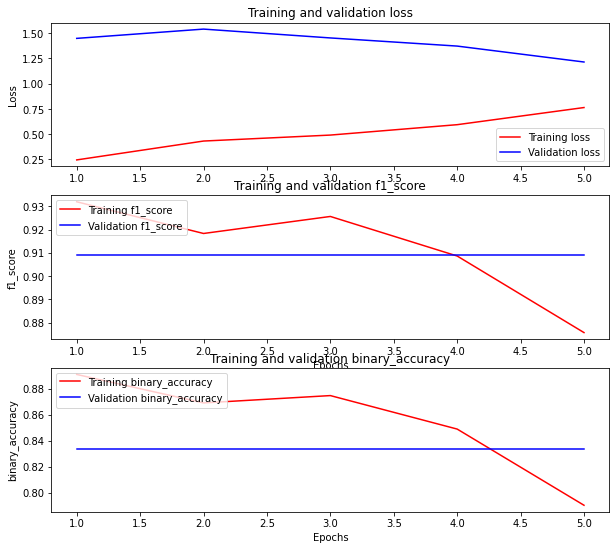

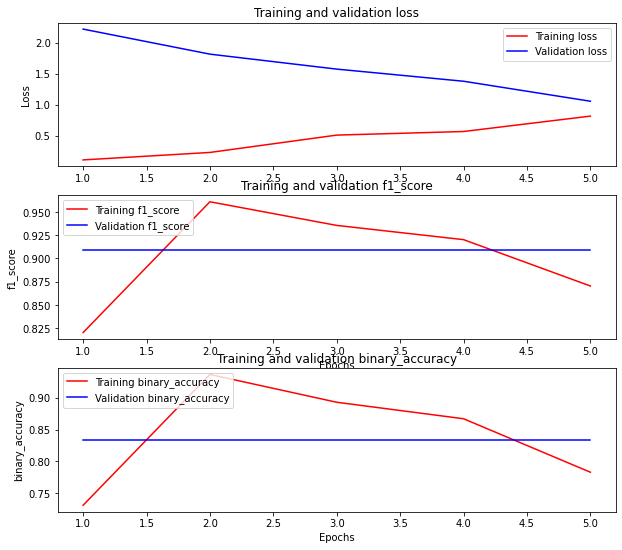

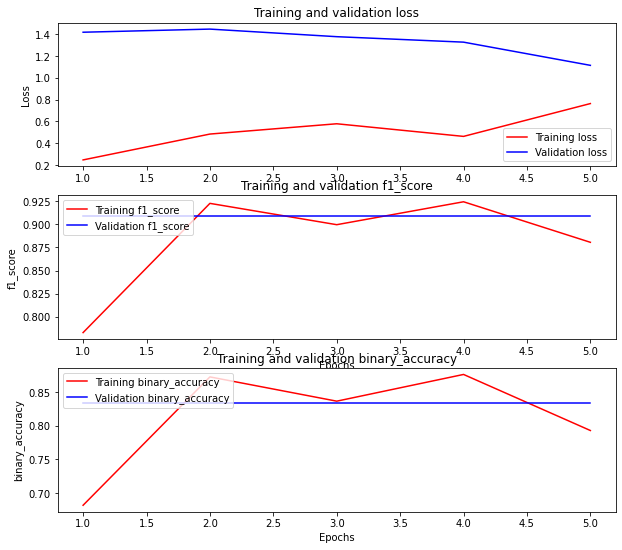

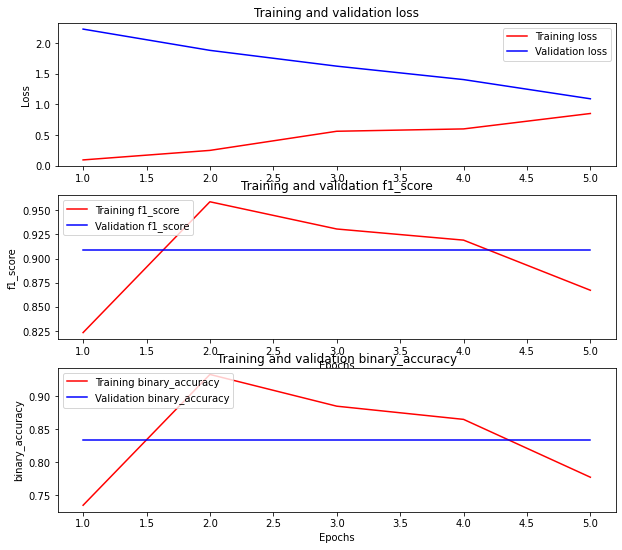

In [ ]:
dropouts = [.2,.4]
lrs = [1e-5, 1e-3]

evluation_datasets = [
    twitter_hatespeech_loose,
    twitter_hatespeech_strict,
    political,
    wikipedia,
    reddit
]

training_dataset = political_over

model, stats = tune_and_run_bert(training_dataset, evluation_datasets, dropouts = dropouts, lrs = lrs)



#### DROPOUT: 0.2, INIT_LR: 1e-05 ####

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Epoch 1/5
388/388 [==============================] - ETA: 0s - loss: 0.2981 - f1_score: 0.9363 - binary_accuracy: 0.8992
Epoch 1: val_f1_score improved from -inf to 0.86280, saving model to weights.hdf5
388/388 [==============================] - 178s 426ms/step - loss: 0.2981 - f1_score: 0.9363 - binary_accuracy: 0.8992 - val_loss: 2.0942 - val_f1_score: 0.8628 - val_binary_accuracy: 0.7587
Epoch 2/5
388/388 [==============================] - ETA: 0s - loss: 0.5244 - f1_score: 0.9326 - binary_accuracy: 0.8877
Epoch 2: val_f1_score did not improve from 0.86280
388/388 [==============================] - 164s 422ms/step - loss: 0.5244 - f1_score: 0.9326 - binary_accuracy: 0.8877 - val_loss: 2.2223 - val_f1_score: 0.8628 - val_binary_accuracy: 0.7587
Epoch 3/5
388/388 [==============================] - ETA: 0s - loss: 0.5847 - f1_score: 0.9089 - binary_accura

194/194 [==============================] - 29s 151ms/step - loss: 1.4987 - f1_score: 0.9084 - binary_accuracy: 0.8321
loss: 1.4987424612045288
f1_score: 0.90838623046875
binary_accuracy: 0.8321498036384583
194/194 [==============================] - 28s 146ms/step
Evaluating on twitter_loose (test)
BERT (trained on wikipedia)
accuracy: 0.8321497740477728
precision: 0.8321497740477728
sensitivity: 1.0
specificity: 0.0
f1: 0.9083861874559549
TP: 5156, FP: 1040
TN: 0, FN: 0

194/194 [==============================] - 30s 154ms/step - loss: 8.7743 - f1_score: 0.0979 - binary_accuracy: 0.0515
loss: 8.774272918701172
f1_score: 0.09792786091566086
binary_accuracy: 0.05148483067750931
194/194 [==============================] - 28s 145ms/step
Evaluating on twitter_strict (test)
BERT (trained on wikipedia)
accuracy: 0.051484828921885085
precision: 0.051484828921885085
sensitivity: 1.0
specificity: 0.0
f1: 0.09792785878741365
TP: 319, FP: 5877
TN: 0, FN: 0

19/19 [==============================] -

194/194 [==============================] - 29s 151ms/step - loss: 2.3178 - f1_score: 0.9084 - binary_accuracy: 0.8321
loss: 2.317760705947876
f1_score: 0.90838623046875
binary_accuracy: 0.8321498036384583
194/194 [==============================] - 28s 146ms/step
Evaluating on twitter_loose (test)
BERT (trained on wikipedia)
accuracy: 0.8321497740477728
precision: 0.8321497740477728
sensitivity: 1.0
specificity: 0.0
f1: 0.9083861874559549
TP: 5156, FP: 1040
TN: 0, FN: 0

194/194 [==============================] - 29s 150ms/step - loss: 13.0977 - f1_score: 0.0979 - binary_accuracy: 0.0515
loss: 13.097695350646973
f1_score: 0.09792786091566086
binary_accuracy: 0.05148483067750931
194/194 [==============================] - 28s 146ms/step
Evaluating on twitter_strict (test)
BERT (trained on wikipedia)
accuracy: 0.051484828921885085
precision: 0.051484828921885085
sensitivity: 1.0
specificity: 0.0
f1: 0.09792785878741365
TP: 319, FP: 5877
TN: 0, FN: 0

19/19 [==============================] 

194/194 [==============================] - 30s 156ms/step - loss: 1.0382 - f1_score: 0.9084 - binary_accuracy: 0.8321
loss: 1.0382063388824463
f1_score: 0.90838623046875
binary_accuracy: 0.8321498036384583
194/194 [==============================] - 28s 146ms/step
Evaluating on twitter_loose (test)
BERT (trained on wikipedia)
accuracy: 0.8321497740477728
precision: 0.8321497740477728
sensitivity: 1.0
specificity: 0.0
f1: 0.9083861874559549
TP: 5156, FP: 1040
TN: 0, FN: 0

194/194 [==============================] - 29s 149ms/step - loss: 7.1072 - f1_score: 0.0979 - binary_accuracy: 0.0515
loss: 7.107243537902832
f1_score: 0.09792786091566086
binary_accuracy: 0.05148483067750931
194/194 [==============================] - 28s 145ms/step
Evaluating on twitter_strict (test)
BERT (trained on wikipedia)
accuracy: 0.051484828921885085
precision: 0.051484828921885085
sensitivity: 1.0
specificity: 0.0
f1: 0.09792785878741365
TP: 319, FP: 5877
TN: 0, FN: 0

19/19 [==============================] -

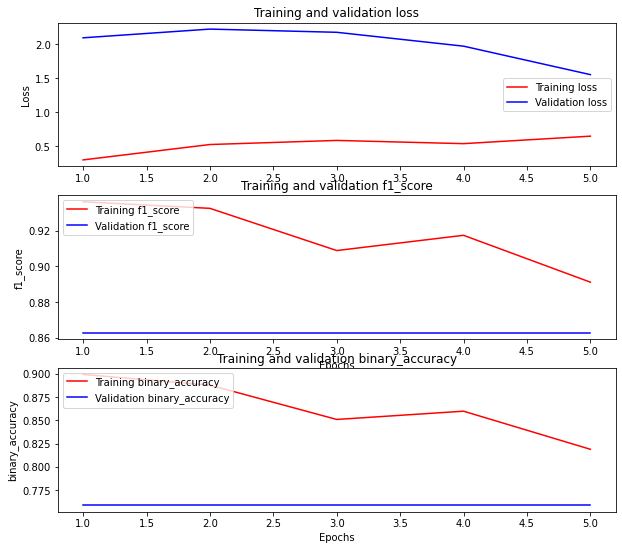

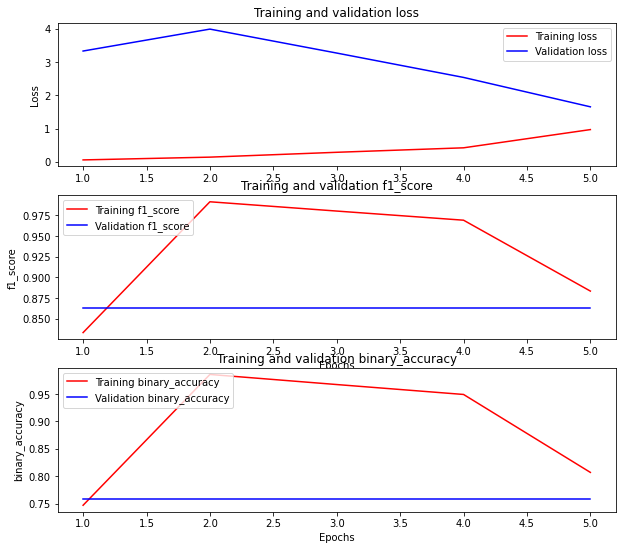

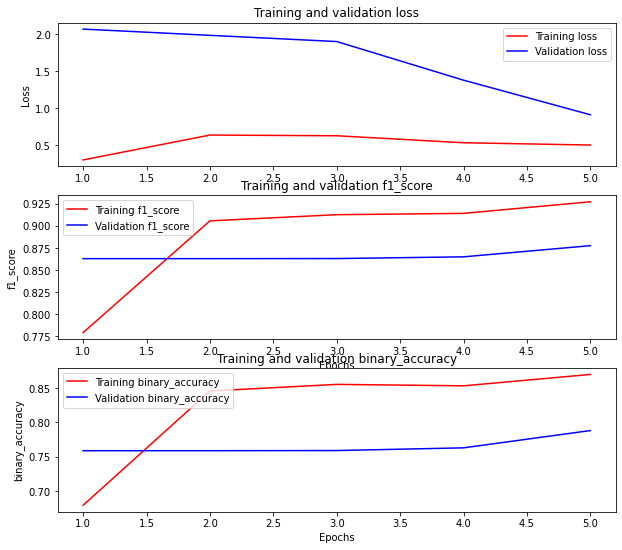

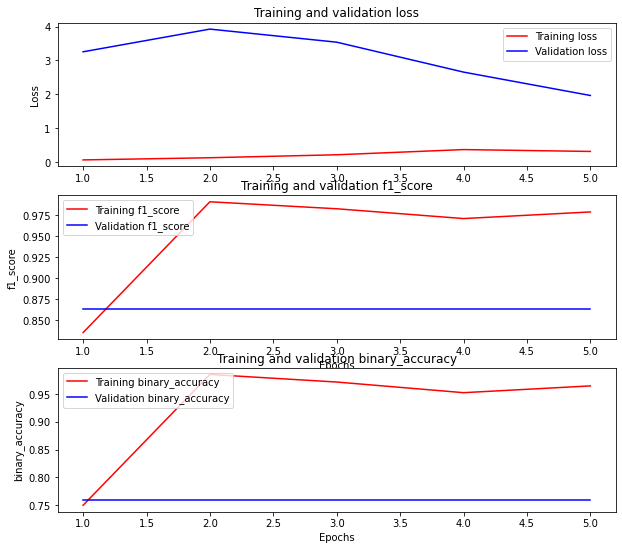

In [ ]:
dropouts = [.2,.4]
lrs = [1e-5, 1e-3]

evluation_datasets = [
    twitter_hatespeech_loose,
    twitter_hatespeech_strict,
    political,
    wikipedia,
    reddit
]

training_dataset = wikipedia_under

model, stats = tune_and_run_bert(training_dataset, evluation_datasets, dropouts = dropouts, lrs = lrs)


## Installation and Imports

In [ ]:
print("tensorflow")
!pip install -q -U "tensorflow==2.9.*"
print("tensorflow-text")
!pip install -q -U "tensorflow-text==2.9.*"
print("tf-models-official")
!pip install -q -U "tf-models-official==2.9.*"
print("tensorflow-addons")
!pip install -q "tensorflow-addons"

tensorflow
     |████████████████████████████████| 511.8 MB 25 kB/s 
tensorflow-text
     |████████████████████████████████| 4.6 MB 32.8 MB/s 
tf-models-official
     |████████████████████████████████| 2.1 MB 39.1 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 352 kB 73.2 MB/s 
     |████████████████████████████████| 1.3 MB 64.9 MB/s 
     |████████████████████████████████| 1.1 MB 67.7 MB/s 
     |████████████████████████████████| 662 kB 67.1 MB/s 
     |████████████████████████████████| 118 kB 63.8 MB/s 
     |████████████████████████████████| 238 kB 66.3 MB/s 
tensorflow-addons


In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## Setup Datasets

In [ ]:
class_names = ["Not Problematic", "Problematic"]
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

def create_keras_dataset(dataset):
    def create_keras_dataset_single(X, y):
        ds = tf.data.Dataset.from_tensor_slices((as_1d(X), as_1d(y)))
        ds = ds.batch(batch_size)
        ds = ds.cache().prefetch(buffer_size=AUTOTUNE)
        return ds
    train_ds = create_keras_dataset_single(dataset.train_x, dataset.train_y)
    dev_ds = create_keras_dataset_single(dataset.dev_x, dataset.dev_y)
    test_ds = create_keras_dataset_single(dataset.test_x, dataset.test_y)
    return train_ds, dev_ds, test_ds

def create_keras_dataset_combo(train_x, train_y, dev_x, dev_y, test_x, test_y):
    def create_keras_dataset_single(X, y):
        ds = tf.data.Dataset.from_tensor_slices((as_1d(X), as_1d(y)))
        ds = ds.batch(batch_size)
        ds = ds.cache().prefetch(buffer_size=AUTOTUNE)
        return ds
    train_ds = create_keras_dataset_single(train_x, train_y)
    dev_ds = create_keras_dataset_single(dev_x, dev_y)
    test_ds = create_keras_dataset_single(test_x, test_y)
    return train_ds, dev_ds, test_ds

## Choose training dataset

Edit the below cell to change which dataset is used to train our BERT model

In [ ]:
##### Edit this cell ####
# training_dataset_name = "loose_political_wikipedia"
# training_dataset_name = "loose_political_reddit"
training_dataset_name = "loose_wikipedia_reddit"
# training_dataset_name = "political_wikipedia_reddit"

In [ ]:
###### Edit this cell #####
'''
training_ds_tuple = create_keras_dataset_combo(loose_political_wikipedia_train_x, loose_political_wikipedia_train_y,
                                              loose_political_wikipedia_dev_x, loose_political_wikipedia_dev_y,
                                               loose_political_wikipedia_test_x, loose_political_wikipedia_test_y)
'''

'''
training_ds_tuple = create_keras_dataset_combo(loose_political_reddit_train_x, loose_political_reddit_train_y,
                                              loose_political_reddit_dev_x, loose_political_reddit_dev_y,
                                               loose_political_reddit_test_x, loose_political_reddit_test_y)
'''

training_ds_tuple = create_keras_dataset_combo(loose_wikipedia_reddit_train_x, loose_wikipedia_reddit_train_y,
                                              loose_wikipedia_reddit_dev_x, loose_wikipedia_reddit_dev_y,
                                               loose_wikipedia_reddit_test_x, loose_wikipedia_reddit_test_y)

'''
training_ds_tuple = create_keras_dataset_combo(political_wikipedia_reddit_train_x, political_wikipedia_reddit_train_y,
                                              political_wikipedia_reddit_dev_x, political_wikipedia_reddit_dev_y,
                                               political_wikipedia_reddit_test_x, political_wikipedia_reddit_test_y)
'''

train_ds, val_ds, test_ds = training_ds_tuple

ValueError: ignored

## Setup Model

In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-8_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

dropout = 0.3

def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(dropout)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)
    
classifier_model = build_classifier_model()

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
metrics = [
    tfa.metrics.F1Score(num_classes=2, threshold=0.5, average="micro"),
    tf.keras.metrics.BinaryAccuracy(),
]
metric_names = [
    "f1_score",
    "binary_accuracy"
]

In [ ]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 1e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

## Train Model

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath="weights.hdf5", monitor="val_f1_score", mode='max', verbose=1, save_weights_only=True, save_best_only=True)

print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               callbacks=[checkpointer])
classifier_model.load_weights('weights.hdf5')

In [ ]:
loss, *metrics = classifier_model.evaluate(test_ds)

print(f'loss: {loss}')
for metric, metric_name in zip(metrics, metric_names):
    print(f'{metric_name}: {metric}')

y_pred = classifier_model.predict(test_ds) > 0.5

#### Edit y_true dataset ####
# y_true = loose_political_wikipedia_test_y
# y_true = loose_political_reddit_test_y
y_true = loose_wikipedia_reddit_test_y
# y_true = political_wikipedia_reddit_test_y

print_metrics(y_pred, y_true, f"BERT", f"Evaluating on {training_dataset_name} (test)")

In [ ]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

num_epochs = len(loss)
num_rows = len(metric_names) + 1
epochs = range(1, num_epochs + 1)
fig = plt.figure(figsize=(10, 3 * num_rows))
fig.tight_layout()

plt.subplot(num_rows, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

for i, metric_name in enumerate(metric_names):
    print(metric_name)
    metric = history_dict[metric_name]
    print("Train:", metric)
    val_metric = history_dict[f'val_{metric_name}']
    print("Validation:", val_metric)

    plt.subplot(num_rows, 1, i + 2)
    plt.plot(epochs, metric, 'r', label=f'Training {metric_name}')
    plt.plot(epochs, val_metric, 'b', label=f'Validation {metric_name}')
    plt.title(f'Training and validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

In [ ]:
import time
from google.colab import files

trained_model_path = f"./saved_bert_{training_dataset_name}_{time.strftime('%Y%m%d-%H%M%S')}"

classifier_model.save(trained_model_path, include_optimizer=False)

## Choose evaluation dataset
Edit the below cell to change which dataset we are evaluating with our above BERT model

In [ ]:
###### Edit this cell #####
'''
evaluate_dataset = reddit
evaluate_dataset_name = "reddit"
'''

'''
evaluate_dataset = wikipedia
evaluate_dataset_name = "wikipedia"
'''

evaluate_dataset = political
evaluate_dataset_name = "political"

'''
evaluate_dataset = twitter_hatespeech_loose
evaluate_dataset_name = "twitter_hatespeech_loose"
'''

In [ ]:
# Don't edit
eval_ds_tuple =  create_keras_dataset(evaluate_dataset)
eval_train_ds, eval_dev_ds, eval_test_ds = eval_ds_tuple

## Evaluate

In [ ]:
loss, *metrics = classifier_model.evaluate(eval_test_ds)

print(f'loss: {loss}')
for metric, metric_name in zip(metrics, metric_names):
    print(f'{metric_name}: {metric}')

y_pred = (classifier_model.predict(eval_test_ds)) > 0.5
y_true = evaluate_dataset.test_y

print_metrics(y_pred, y_true, f"BERT (trained on {training_dataset_name})", f"Evaluating on {evaluate_dataset_name} (test)")

# Error Analysis

In [ ]:
#Edit for different datasets
predicted = pd.DataFrame(y_pred)
predicted.columns = ['predicted']
predicted.to_csv('train_preds.csv', index = False)

In [ ]:
#Edit for different datasets
df_train_label = pd.DataFrame(y_true)
df_train_label.columns = ['target']
df_train_text = pd.DataFrame(x_true)
df_train_text.columns = ['text']
df_train = pd.concat([df_train_text, df_train_label], axis = 1, sort = False)
df_train_preproc = df_train
df_train_preproc.to_csv('df_train_preprocessed.csv')
df_train_preproc = pd.read_csv("df_train_preprocessed.csv")
train_preds = pd.read_csv('train_preds.csv')

In [ ]:
# Real values of train data
df_train[0:10].T

,0,1,2,3,4,5,6,7,8,9
text,"There are people I follow who 18 months ago were very fired up about child poverty in the United States but don’t seem to care much about it now, seemingly because Biden has a great program on child poverty. [NEWLINE][NEWLINE]https://t.co/IGQmPgsbdB","@realDonaldTrump Why would the government stop this when our “President “ is among those guiltiest? Money launder much,Trump? #TrumpCorruption,#TrumpCrime,#VoteTrumpOutToSaveAmerica,#Biden2020- https://t.co/3hO8idgpAU",Preach brotha! 🙌 #BidenHarris2020 https://t.co/7RNEN85gdj,@jrgaillot @JoeBiden class act #GOTV #genz #Millennials #COVID19 #RepublicansForBiden #EarlyVoting #EarlyVote #AbsenteeBallot #TeamJoe #BidenHarris2020,"Okay white women, to the 53% of you who made a terrible decision 4 years ago, I hope you’ve been paying attention and don’t vote for a sexist white supremacist again. Do better. #VoteHimOut #grabhimbytheballot #BidenHarris2020",@60Minutes needs to end the show or @NorahODonnell contract! What a disgrace. Norah needs 2 apologize 2 Joe Biden &amp; Kamala Harris 4 being completely unprofessional on air. 60 mins has fallen a long way. Being rude 2 any guest is unacceptable. My prediction. They never get another https://t.co/UAYiCxKnPI,@dancer39532 @realDonaldTrump Joe Biden’s a racist and even Kamala Harris called him out for it https://t.co/zfNMBoRbiR,"@Rett94291220 @STLemmon @LizRNC Kamala Harris said she believed Joe Biden’s sexual assault accuser. Both parties are riddled with contradictions, however, the Democrats seem to be more violent to those they disagree with",@realDonaldTrump Cuz we're smart here. Now give Ivanka your phone and go back to bed. [NEWLINE][NEWLINE]#BidenHarris2020 #ByeDon2020 #VoteThemOut #PennsylvaniaForBiden #TyphoidDonny #VoteBlueToEndThisNightmare #TrumpIsANationalDisgrace #Resist,@ChristianWalk1r It’ll be over in November! #Trump2020
target,0,0,0,0,1,0,0,0,1,0


In [ ]:
# Our predicted values
train_preds[0:10].T

,0,1,2,3,4,5,6,7,8,9
predicted,False,False,False,False,True,False,False,False,True,False


In [ ]:
#Combine real and predicted
combined = pd.concat([df_train, train_preds], axis = 1, sort = False)
combined.head()

,text,target,predicted
0,"There are people I follow who 18 months ago were very fired up about child poverty in the United States but don’t seem to care much about it now, seemingly because Biden has a great program on child poverty. [NEWLINE][NEWLINE]https://t.co/IGQmPgsbdB",0,False
1,"@realDonaldTrump Why would the government stop this when our “President “ is among those guiltiest? Money launder much,Trump? #TrumpCorruption,#TrumpCrime,#VoteTrumpOutToSaveAmerica,#Biden2020- https://t.co/3hO8idgpAU",0,False
2,Preach brotha! 🙌 #BidenHarris2020 https://t.co/7RNEN85gdj,0,False
3,@jrgaillot @JoeBiden class act #GOTV #genz #Millennials #COVID19 #RepublicansForBiden #EarlyVoting #EarlyVote #AbsenteeBallot #TeamJoe #BidenHarris2020,0,False
4,"Okay white women, to the 53% of you who made a terrible decision 4 years ago, I hope you’ve been paying attention and don’t vote for a sexist white supremacist again. Do better. #VoteHimOut #grabhimbytheballot #BidenHarris2020",1,True


In [ ]:
# Size of error = |real  - predicted|
combined['error'] = abs(combined['target'] - combined['predicted'])

In [ ]:
# Change text to full view
pd.set_option('display.max_colwidth', -1) 

<ipython-input-143-270201e553c7>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [ ]:
# Sort the items in decreasing order of error amount
sorted = combined.sort_values(by = ['error'], ascending = False)

In [ ]:
# False Positive- Not Hate speech but predicted strongly as hate speech
sorted[sorted['target'] == 0][0:10]

,text,target,predicted,error
382,"@KamalaHarris @JoeBiden Dominate and Annihilate trump, Joe aka 46 🇺🇲 #BidenHarris2020 #WinningTeam #PresidentialDebate #TrumpTaxReturns #TrumpHatesOurMilitary #TrumpKnew #TrumpLiedPeopleDied[NEWLINE][NEWLINE]GO JOE 📣🗳️👏👏🌊🌊🌊🌊🌊🌊",0,True,1
220,#TrumpIsATraitor #BidenHarris2020ToSaveAmerica #BREAKING #Trending #BidenHarris #BidenHarris2020 #Debates2020 #kimberly #Blacklivesmatter [NEWLINE][NEWLINE]LAUGHING MY FUCKING ASS OFF BEECH[NEWLINE][NEWLINE]HOUSE OF CARDS IS COLLAPSING https://t.co/G0IkypAQK2 https://t.co/huvYRlLJEo,0,True,1
232,"@GOPLeader KevinMcCarthy, do u ever tire of the lies and divisive rhetoric?[NEWLINE][NEWLINE]The #American people are no longer fooled by #Trump enablers [NEWLINE][NEWLINE]American people are desperate for honesty, integrity and leadership[NEWLINE][NEWLINE]Your nonstop finger-pointing is exhausting[NEWLINE][NEWLINE]#Democracy #Biden2020",0,True,1
510,@GOPChairwoman Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE][NEWLINE]That’s all you Trump cult geniuses know how to do.,0,True,1
389,"Don’t compare Johnstown to Jonestown. Jim Jones had his goons point guns at his followers in order to get them to drink the cyanide, Trump’s supporters are drinking it voluntarily. 🙁 https://t.co/LI3DEa5E1x",0,True,1
384,People are saying that the #RIPGOP is need of money?[NEWLINE]tRump has 100's Lawyers on the payroll w/kickbacks and you wonder where the money went?[NEWLINE]#RrealDonaldTrump #MAGA2020 #KAG2020 [NEWLINE]You're Money!! #VoteBlueToEndThisNightmare,0,True,1
82,"@MarshaBlackburn @realDonaldTrump You really are a shameless and unrepentant #liar. If you can look in the mirror without throwing up on your shoes, I’d be surprised. #ShutUp. #BidenHarris2020",0,True,1
75,"@JesusisLord4God @rikjam1 @truth @JoeBiden Says a dolt who retweets Trump and James Woods.[NEWLINE][NEWLINE]If they are your moral compass, you have bigger problems than worrying about Biden. God bless.[NEWLINE][NEWLINE]#TrumpMeltdown[NEWLINE]#TrumpIsALaughingStock [NEWLINE]#BidenHarris2020",0,True,1
261,"@TeamCollins207 No. No, and NO! This is so disingenuous - even for you! (and I'm a cow) #MEPolitics #TimeForPasture #SelloutSuzy #VoteBlue2020",0,True,1
268,😂😂😂 wonder if she understands how Self righteous that made her sound. [NEWLINE] My 4 year old heard Joe biden call the POTUS a clown and yelled your the clown Joe biden 🤣🤣🤣 ... I high fived her 🤷‍♀️ were not the same[NEWLINE][NEWLINE]#Trump2020 [NEWLINE]#PrideFamily #PrideNews1 https://t.co/hECLYif31n,0,True,1


In [ ]:
# False negatives - Hate speech but predicted as not hate speech
pd.options.display.float_format = "{:.8f}".format
# Select texts where true target was 1
normal_speech = sorted[sorted['target'] == 1]
normal_speech[0:10]

,text,target,predicted,error
501,"@IngrahamAngle Does Joe have any clue as to how fast his party will be taking him out if he wins? Such a farce. He would be president for maybe a day, maybe a week before they claim he has dementia, is unfit and they advance that giggling nit wit Kamala.",1,False,1
230,The @realDonaldTrump Coward's List I was going to tweet. It's ALL A #TrumpCovid LIE to make himself look good &amp; avoid further debates. #TraitorTrump #Trump2020 @BrunosWahine Well done @ImdoneMike 😎👍 https://t.co/a4tTeUghzQ,1,False,1
393,@JustinYselonia @funder Its going to be interesting to see Kamala Harris and Pelosi grease Joe's ass with the 25th Amendment next year. This is an example of why this will be so successful. At least we will all be screwed together. https://t.co/0JIXngNZDT,1,False,1
391,"@FreedomWorks Yep, #ChinaBiden... needs more #ChinaMoney to line those pockets before he retires! #Trump2020",1,False,1
240,@gofakeyourselfM @kirstiealley HORRIBLE KAMALA WILL NEVER BE PRESIDENT !!!! NEITHER WILL SLOW CREEPY JOE !!!,1,False,1
387,"@Ihateitwhenmen1 @realDonaldTrump Shut the fuck up,what did Obama do for 8 year hun,trump did more than Obama In just 4 years",1,False,1
243,2 Kamala Harris staffers have covid-19. Let's hope at least one of them has been recently sniffed by Creepy Joe.,1,False,1
93,"I will now sit back, enjoy the rest of my twitter feed, block liberal bleeding turdwhipes of all shapes, sizes, religions and ethnicities ... and when November 3 comes, I will vote Republican down the whole ticket #MAGADragTheInterstate #MAGA2020[NEWLINE]#TurnAmericaRed2020",1,False,1
521,This is BS. If he repeals the Trump tax cut it will in fact increase taxes for EVERYONE https://t.co/Fy85VhsN7O,1,False,1
76,"Jacksonville residents, do you want people in our city government that align with a trump sycophant who was willing to expose us to Covid for political gain? Or do you want effective change by people that will work for you? [NEWLINE]Vote out all the people that associate with this guy👇 https://t.co/us0fHP9REc",1,False,1


In [ ]:
# Most correct predictions
sorted_increasing = combined.sort_values(by = ['error'], ascending = True)
sorted_increasing[0:10]

,text,target,predicted,error
0,"There are people I follow who 18 months ago were very fired up about child poverty in the United States but don’t seem to care much about it now, seemingly because Biden has a great program on child poverty. [NEWLINE][NEWLINE]https://t.co/IGQmPgsbdB",0,False,0
400,@HellBentVet @Alyssa_Milano Lmao look at you. Dissing the people who would even think about donating to your paypal. Sorry not sorry. #TRUMP2020,0,False,0
399,I hereby declare Joe Biden as my president and Kamala Harris as my Vice President!! Do you?!?,0,False,0
398,@realDonaldTrump @TeamTrump I have important work to do right now. But it makes me sick seeing all the crap that trump is doing to stay in power. He simply can't get more time to destroy our country. Can't have #DictatorTrump #VoteHimOut #BidenHarris2020,0,False,0
397,"NOT WELL 😷🥵🤒🤕🤧🤮[NEWLINE]#DONALDDEATH 207,000+ AMERICANS MURDERED BY @realDonaldTrump 😥😓🤧😵[NEWLINE]#VOTEHIMOUT 😤😠🤬🤯[NEWLINE]#LYINGDONALD 🤬😠[NEWLINE]#CROOKEDtrump 😱😈🤡[NEWLINE]#RUSSIANASSET[NEWLINE]#BIDENHARRIS2020 🌊🇺🇸✊🏿🤘🏻💯 https://t.co/YxvF1TSWTh",1,True,0
396,How do you trust and vote for this current #TrumpAdministration with all these sick politicians? They don’t even lead by example. #plague #TrumpLiesAmericansDie #BidenHarris2020,0,False,0
395,Covid sex? NOPE. Please win Biden #BidenHarris2020,0,False,0
394,"If I were in charge, I would subpoena Joe Biden's bank accounts, Rosemont Seneca's bank accounts &amp; check any large purchases Joe mad in cash.[NEWLINE]After all, he's running for President! We must know if any 💰 was funnelled to him.[NEWLINE]#MoscowHunter [NEWLINE]#WednesdayWisdom [NEWLINE]#Biden [NEWLINE]#MAGA2020 https://t.co/T1qOc5yBTp",0,False,0
392,"Absolutely. Stop wrapping this bloated draft-dodging tax cheat in the flag and vote for a real patriot who won’t dismiss 204,000 dead Americans as “It is what it is.” #BidenHarris2020 https://t.co/P9TkZmLvZo",0,False,0
390,@jackytreeh0rn @Oregonian And they will again in a month. The GOP will be weakened in the long term by blindly following Trump.,0,False,0


In [ ]:
#Shortest and longest text 
combined['text_length'] = combined['text'].apply(lambda x: len(x))

In [ ]:
# Shortest text
sorted_len = combined.sort_values(by = ['text_length'], ascending = True)
sorted_len[0:10]

,text,target,predicted,error,text_length
254,@ajplus Do not elect trump!,0,False,0,27
352,@JoeBiden SHUT IT #MAGA2020 🇺🇸,0,False,0,30
266,END the Left! NOW ! #TRUMP2020,0,False,0,30
259,@ThunderB Won't stop him. #Trump2020,0,False,0,36
283,"@JoeBiden Yeah, LETS! #TrumpPence2020",0,False,0,37
257,@AmericanVoR NOT HERE #BidenHarris2020,0,False,0,38
72,"@JoeBiden I'm in, Rev. #BidenHarris2020",0,False,0,39
64,Trump must have stock in Regeneron 🤦🏾‍♂️,0,False,0,40
543,@MagicJohnson Is True !! #trump2020 #AmericaFirst,0,False,0,49
395,Covid sex? NOPE. Please win Biden #BidenHarris2020,0,False,0,50


In [ ]:
# Longest text
sorted_len.iloc[::-1][0:10]

,text,target,predicted,error,text_length
510,@GOPChairwoman Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE]Whine[NEWLINE][NEWLINE]That’s all you Trump cult geniuses know how to do.,0,True,1,536
314,PRINCE PHILIP⚫👑[NEWLINE]QUEEN ELIZABETH II⚪👑[NEWLINE]THE BRITISH AUTHORITIES🇬🇧[NEWLINE](NÉ⚓) KATE🇬🇧 [NEWLINE]RABYN🌿🇧🇧 &amp; KAT♠[NEWLINE]PRINCESS KAMALA🎲[NEWLINE]PRINCE AHHYGAH BERLIN🇬🇧🌿[NEWLINE][NEWLINE]RABYN🌿[NEWLINE]we cant even talk🚔[NEWLINE]once in office[NEWLINE][NEWLINE]wait/why?[NEWLINE][NEWLINE]cc: president donald j. trump[NEWLINE]CC: PRESIDENT JOE BIDEN[NEWLINE]CC: VP KAMALA HARRIS🇺🇸🇫🇷🍑,0,False,0,400
364,@DamianWolf19 @snickypoo49 @LaurieKaftanic @pergolaman @lwootton @beachtimeagain @Tru561 @CarbonMonoxid17 @goody_tracy @AmericaIsDamned @cpdagosta @dougbva @jfdeegan @KrisRocco2 @RedReader5252 @BobDog444 @0802_lillith @IBelizeit @StepheninLa Thank you for the mention! [NEWLINE]Everyone excited about the debate tonight? Hope you have snacks! 🌊[NEWLINE]#BidenHarris2020 https://t.co/uTWH5XJ1LE,0,False,0,393
25,"Question y'all....[NEWLINE][NEWLINE]Now I know every single network is gonna be showing the same feed, but where y'all tuning in?[NEWLINE][NEWLINE]CNN, MSNBC, CBS, NBC, ABC, FOX (yeah, no) or any others? Just curious who to watch![NEWLINE][NEWLINE]Comment below please![NEWLINE][NEWLINE]#VOTE [NEWLINE]#debates [NEWLINE]#Debates2020 [NEWLINE]#BidenHarris2020 [NEWLINE]🇺🇲🗳️🌊",0,False,0,373
567,"@dinosaurgirl @donwinslow @danpfeiffer Couple of Dan's observations:[NEWLINE][NEWLINE]...Trump has been at least ""authoritarian curious.""[NEWLINE][NEWLINE]...Let's be honest: Trump is not some mastermind criminal... Were he not president, he would end up on one of BuzzFeed's lists of ""America's dumbest criminals,"" ...[NEWLINE][NEWLINE]@BuzzFeed[NEWLINE]#BidenHarris2020",0,False,0,371
413,A united #Resistance is the only thing that can save our nation -FOLLOW ALL WHO: [NEWLINE][NEWLINE]LIKE [NEWLINE]RT[NEWLINE]COMMENT [NEWLINE][NEWLINE]@realDonaldTrump is the biggest POS to ever exist in our entire multi-versal quantum construct &amp; it's time for him to go. [NEWLINE][NEWLINE]#Resist #Biden2020 #CORRUPTDOJ #TraitorTrump https://t.co/3hWfqAavsp,1,False,1,362
370,"#Trump flies around the country SuperSpreading COVID-19 and wild conspiracies at his rallies. Another from a series from @clapanta[NEWLINE]. [NEWLINE]#NationalVoterRegistrationDay [NEWLINE]#Biden[NEWLINE] #Biden2020 [NEWLINE]#TrumpLied200KAmericansdied #VoteBlueToEndThisNightmare [NEWLINE][NEWLINE]If you agree, RT this and SUBSCRIBE https://t.co/XZvWCzieik",0,False,0,360
406,@lesleyabravanel @kayleighmcenany The Left conspired to frame Trump with Russia and hang Brett Kavanaugh in the court of public opinion w/o evidence or due process or the presumption of innocence and then impeached Trump w/o a crime because Trump is the fascist.[NEWLINE][NEWLINE]Meanwhile...[NEWLINE][NEWLINE]#MAGA #Trump2020 #KAG2020 https://t.co/1fVqXJHj0J,0,False,0,359
345,"@EricTrump @nypost @JoeBiden 🦠𝟚𝟘𝟘,𝟘𝟘𝟘 𝔸𝕄𝔼ℝ𝕀ℂ𝔸ℕ𝕊 𝔻𝔼𝔸𝔻🦠[NEWLINE] [NEWLINE]Let’s not lose sight of the fact that @realDonaldTrump completely bungled the United States’ Coronavirus response. He failed miserably. The gig is up in 41 days.[NEWLINE][NEWLINE]#Trump2020 [NEWLINE]#TrumpIsANationalDisgrace [NEWLINE]#TrumpIsALoser[NEWLINE]#Vote https://t.co/lzZFKfCDOe",1,False,1,358
486,"@SureReality @bubbaprog At least Biden wears a mask when dealing with voters, more than Trump has ever done at his rallies rant-spitting on his constituents for hours on end. He loves his people THAT much![NEWLINE][NEWLINE]#TrumpIsATraitor [NEWLINE]#Biden2020 [NE